## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.xgb_helpers import *
from scripts.geodata import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig()

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

"""
# RGI Ids:
# Read rgi ids:
rgi_df = pd.read_csv(path_glacier_ids, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)
"""

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    # "aspect_sgi",  # SGI
    # "slope_sgi",  # SGI
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    # "millan_v",  # OGGM
]

## Read GL data:

In [3]:
data_wgms = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/Nor_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 32
Number of winter, summer and annual samples: 6297
Number of annual samples: 3195
Number of winter samples: 3102
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER', 'aspect',
       'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'POINT_ID'],
      dtype='object')

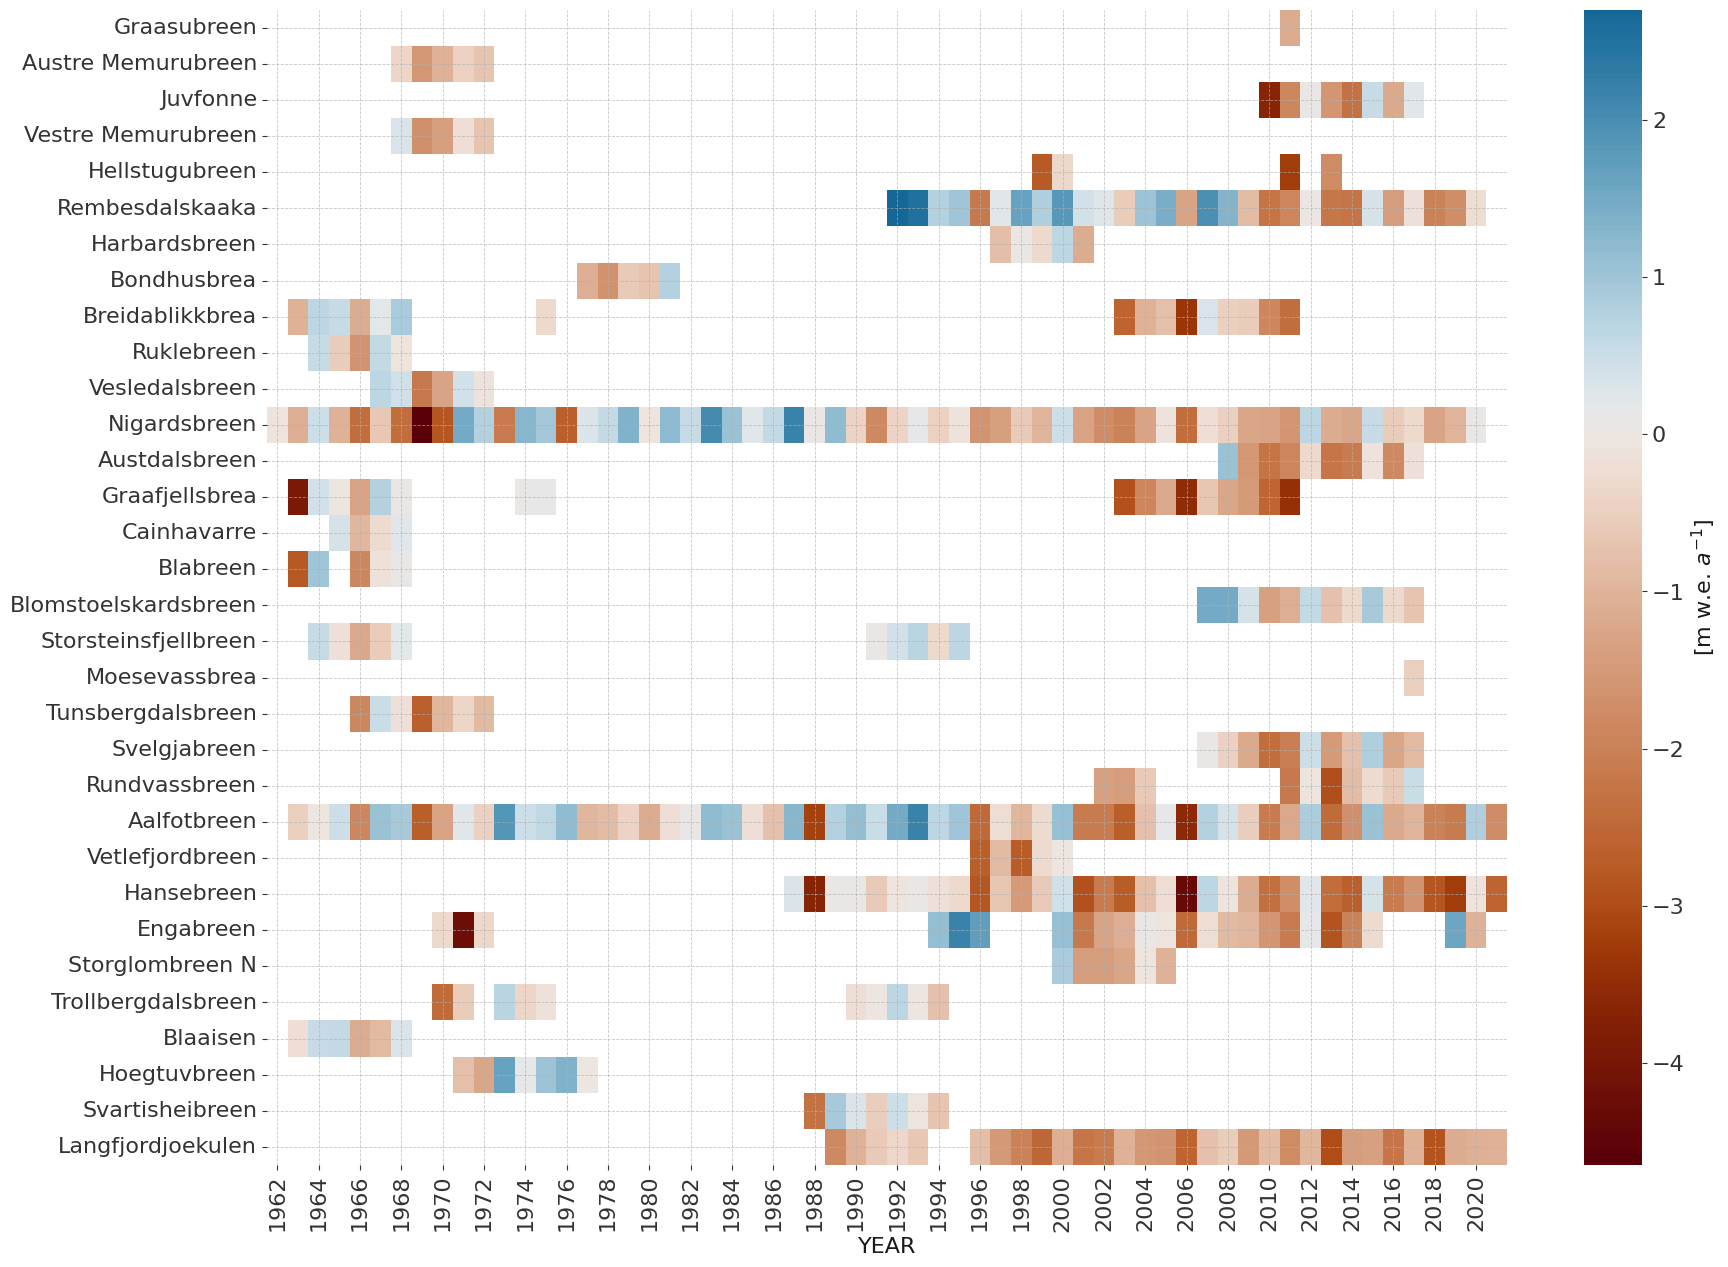

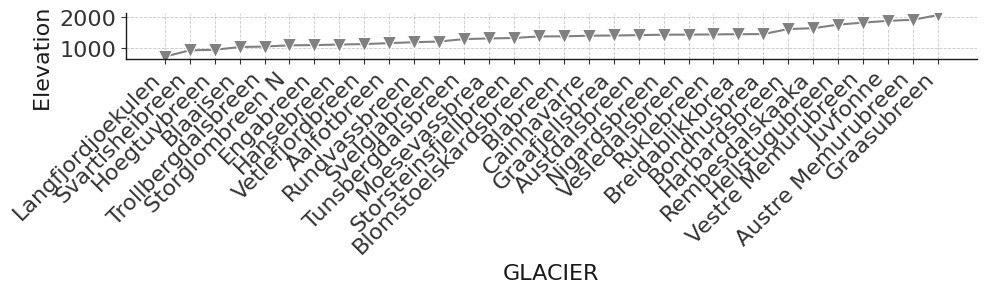

In [4]:
# Heatmap of mean mass balance per glacier:
# Get the mean mass balance per glacier

mean_mb_per_glacier = data_wgms.copy()
mean_mb_per_glacier['YEAR'] = mean_mb_per_glacier['TO_DATE'].astype(str).str[:4].astype(int)

mean_mb_per_glacier = mean_mb_per_glacier.groupby(
    ['GLACIER', 'YEAR', 'PERIOD'])['POINT_BALANCE'].mean().reset_index()
mean_mb_per_glacier = mean_mb_per_glacier[mean_mb_per_glacier['PERIOD'] == 'annual']

matrix = mean_mb_per_glacier.pivot(
    index='GLACIER', columns='YEAR',
    values='POINT_BALANCE').sort_values(by='GLACIER')

# get elevation of glaciers:
gl_per_el = data_wgms.groupby(['GLACIER'])['POINT_ELEVATION'].mean()
gl_per_el = gl_per_el.sort_values(ascending=False)

# Order matrix:
matrix = matrix.loc[gl_per_el.index]
matrix.index = pd.Categorical(matrix.index,
                              categories=matrix.index,
                              ordered=True)

# Plot heatmap:
fig = plt.figure(figsize=(20, 15))
ax = plt.subplot(1, 1, 1)
heatmap = sns.heatmap(
    data=matrix,
    center=0,
    cmap=cm.vik_r,
    cbar_kws={'label': '[m w.e. $a^{-1}$]'},
    ax=ax,
)

# Plot elevation:
fig = plt.figure(figsize=(10, 3))  # Made figure slightly taller for labels
ax = plt.subplot(1, 1, 1)
sorted_elevations = gl_per_el.sort_values(ascending=True)

sns.lineplot(sorted_elevations,
             ax=ax,
             color='gray',
             marker='v')

# Add glacier names as x-tick labels
ax.set_xticks(range(len(sorted_elevations)))
ax.set_xticklabels(sorted_elevations.index, rotation=45, ha='right')
ax.set_ylabel('Elevation [m]')
plt.tight_layout()

In [5]:
data_wgms_test = data_wgms.copy()

display(data_wgms_test.shape)
display(data_wgms_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': path_ERA5_raw + 'era5_monthly_averaged_data.nc',
    'geopotential_data': path_ERA5_raw + 'era5_geopotential_pressure.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

(6297, 16)

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702              471   20120925  20131107          -4.92   
1   70.12578   21.77630              439   20131107  20140924          -2.67   

   PERIOD           RGIId  YEAR            GLACIER     aspect      slope  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen  36.073272  15.972541   
1  annual  RGI60-08.01258  2014  Langfjordjoekulen  33.570984  16.993369   

         topo  hugonnet_dhdt  consensus_ice_thickness  \
0  425.458893      -3.314563                96.980293   
1  434.652008      -2.934460                89.294670   

                          POINT_ID  
0  Langfjordjoekulen_2013_annual_0  
1  Langfjordjoekulen_2014_annual_1

2025-05-13 17:46:24,046 - INFO - Number of annual and seasonal samples: 6297
2025-05-13 17:46:24,048 - INFO - Running on 32 glaciers:
['Langfjordjoekulen' 'Blaaisen' 'Storsteinsfjellbreen' 'Cainhavarre'
 'Rundvassbreen' 'Storglombreen N' 'Engabreen' 'Svartisheibreen'
 'Hoegtuvbreen' 'Trollbergdalsbreen' 'Aalfotbreen' 'Hansebreen'
 'Vetlefjordbreen' 'Nigardsbreen' 'Tunsbergdalsbreen' 'Vesledalsbreen'
 'Austdalsbreen' 'Harbardsbreen' 'Juvfonne' 'Graasubreen' 'Hellstugubreen'
 'Austre Memurubreen' 'Vestre Memurubreen' 'Rembesdalskaaka' 'Blabreen'
 'Graafjellsbrea' 'Breidablikkbrea' 'Ruklebreen' 'Bondhusbrea'
 'Svelgjabreen' 'Moesevassbrea' 'Blomstoelskardsbreen']


2025-05-13 17:46:24,116 - INFO - Number of winter and annual samples: 6297
2025-05-13 17:46:24,118 - INFO - Number of annual samples: 3195
2025-05-13 17:46:24,120 - INFO - Number of winter samples: 3102
2025-05-13 17:46:24,120 - INFO - Adding climate features...
2025-05-13 17:46:34,716 - INFO - Converting to monthly resolution...
2025-05-13 17:46:50,575 - INFO - Number of monthly rows: 60265
2025-05-13 17:46:50,578 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'hugonnet_dhdt', 'consensus_ice_thickness', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-05-13 17:46:51,852 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/NOR_dataset_monthly_full.csv


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  2013   21.77702   70.12589          -4.92        341.344485   
1  2013   21.77702   70.12589          -4.92        341.344485   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            129.655515              471  RGI60-08.01258   
1            129.655515              471  RGI60-08.01258   

                          POINT_ID  ID  ...  consensus_ice_thickness  \
0  Langfjordjoekulen_2013_annual_0   0  ...                96.980293   
1  Langfjordjoekulen_2013_annual_0   0  ...                96.980293   

        t2m        tp      slhf      sshf       ssrd       fal        str  \
0 -0.428070  0.003846  -55354.0  657502.0  2040906.5  0.439741 -2504336.0   
1 -4.780853  0.003902  178386.0  909366.0   157664.0  0.817481 -1714196.0   

        u10       v10  
0 -0.141248  0.397857  
1 -0.183276  1.758524  

[2 rows x 27 columns]

#### Feature Correlation

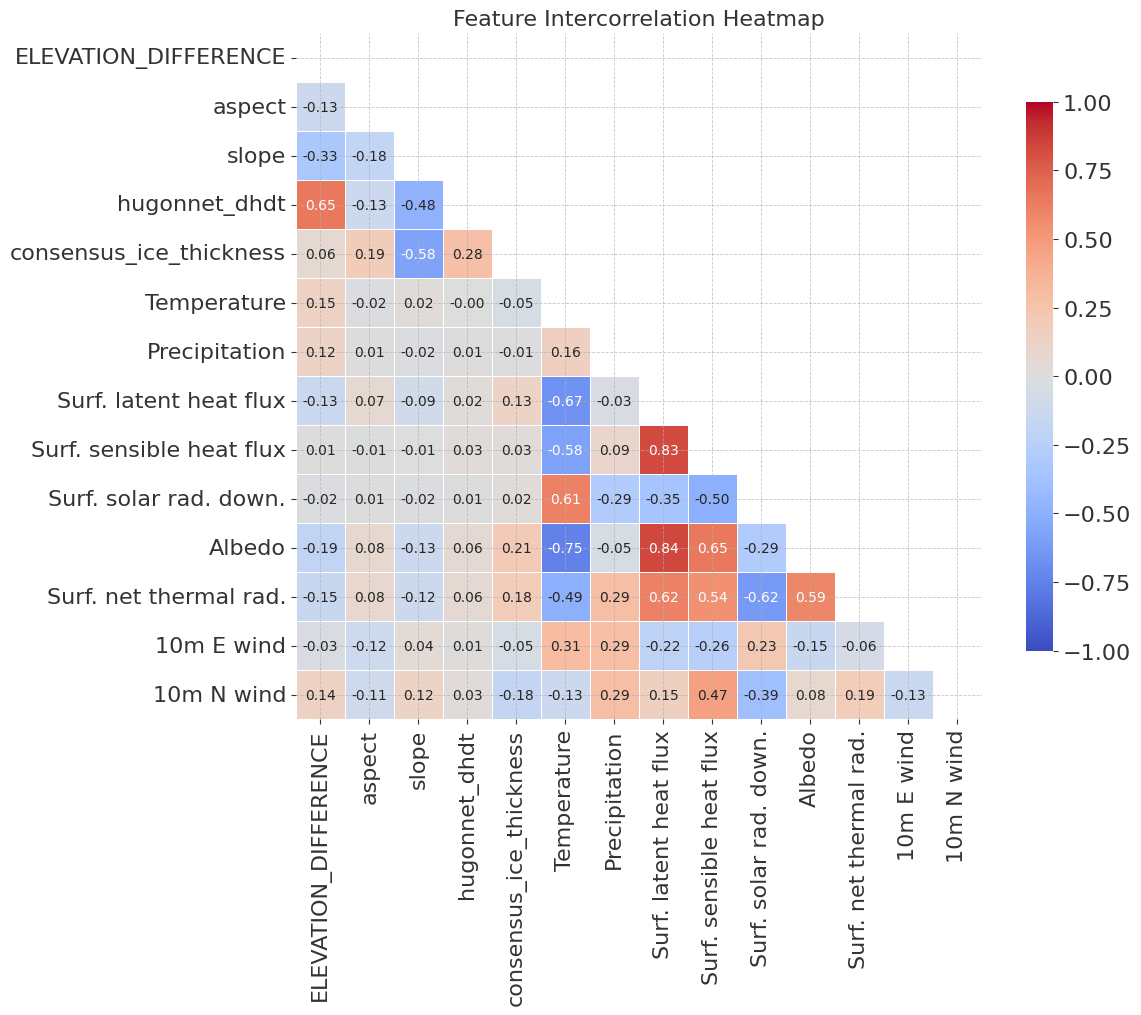

In [6]:
# Prepare data for correlation analysis
df = dataloader_gl.data.copy().dropna()

# Define the columns to keep
columns_to_keep = [
    col for col in df.columns if col not in [
        'GLACIER', 'PERIOD', 'YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE',
        'ALTITUDE_CLIMATE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
        'GLWD_ID', 'N_MONTHS', 'MONTHS'
    ]
]
df = df[columns_to_keep]

# Rename columns based on long names (if applicable)
df.rename(columns=vois_climate_long_name, inplace=True)

# Compute correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap
sns.heatmap(
    corr,
    mask=mask,
    cmap='coolwarm',
    vmax=1,
    vmin=-1,
    center=0,
    annot=True,  # Add correlation values
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8})

# Enhance readability
plt.title("Feature Intercorrelation Heatmap", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

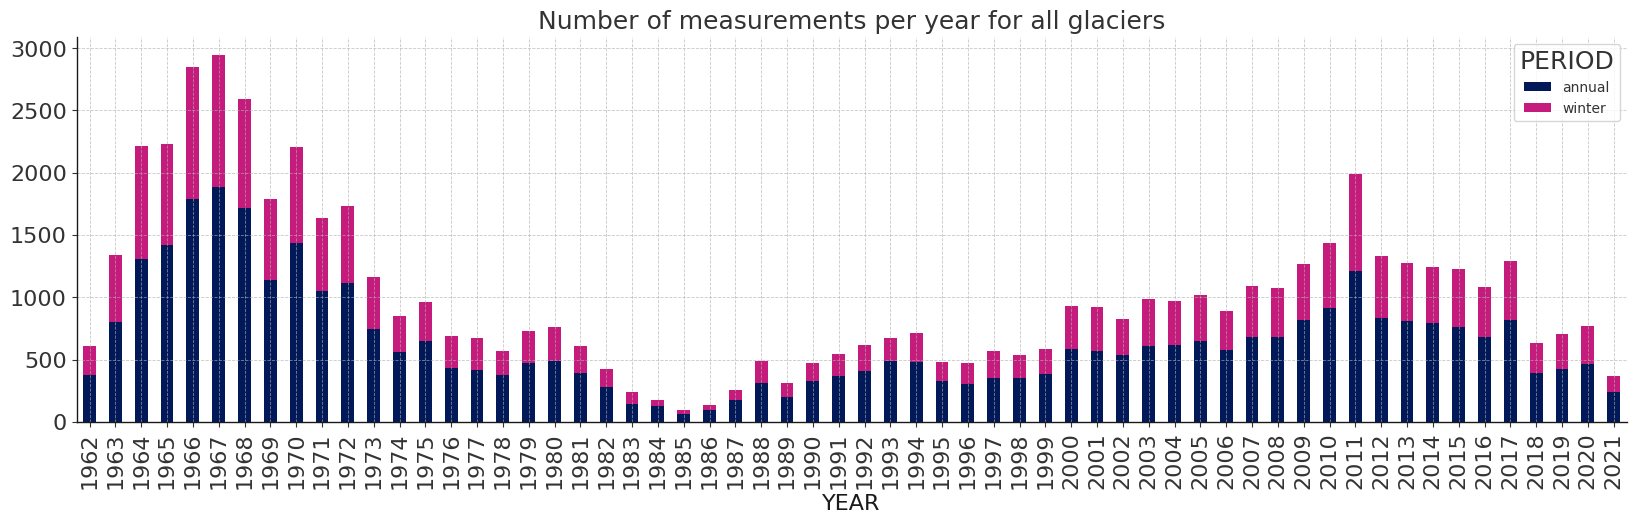

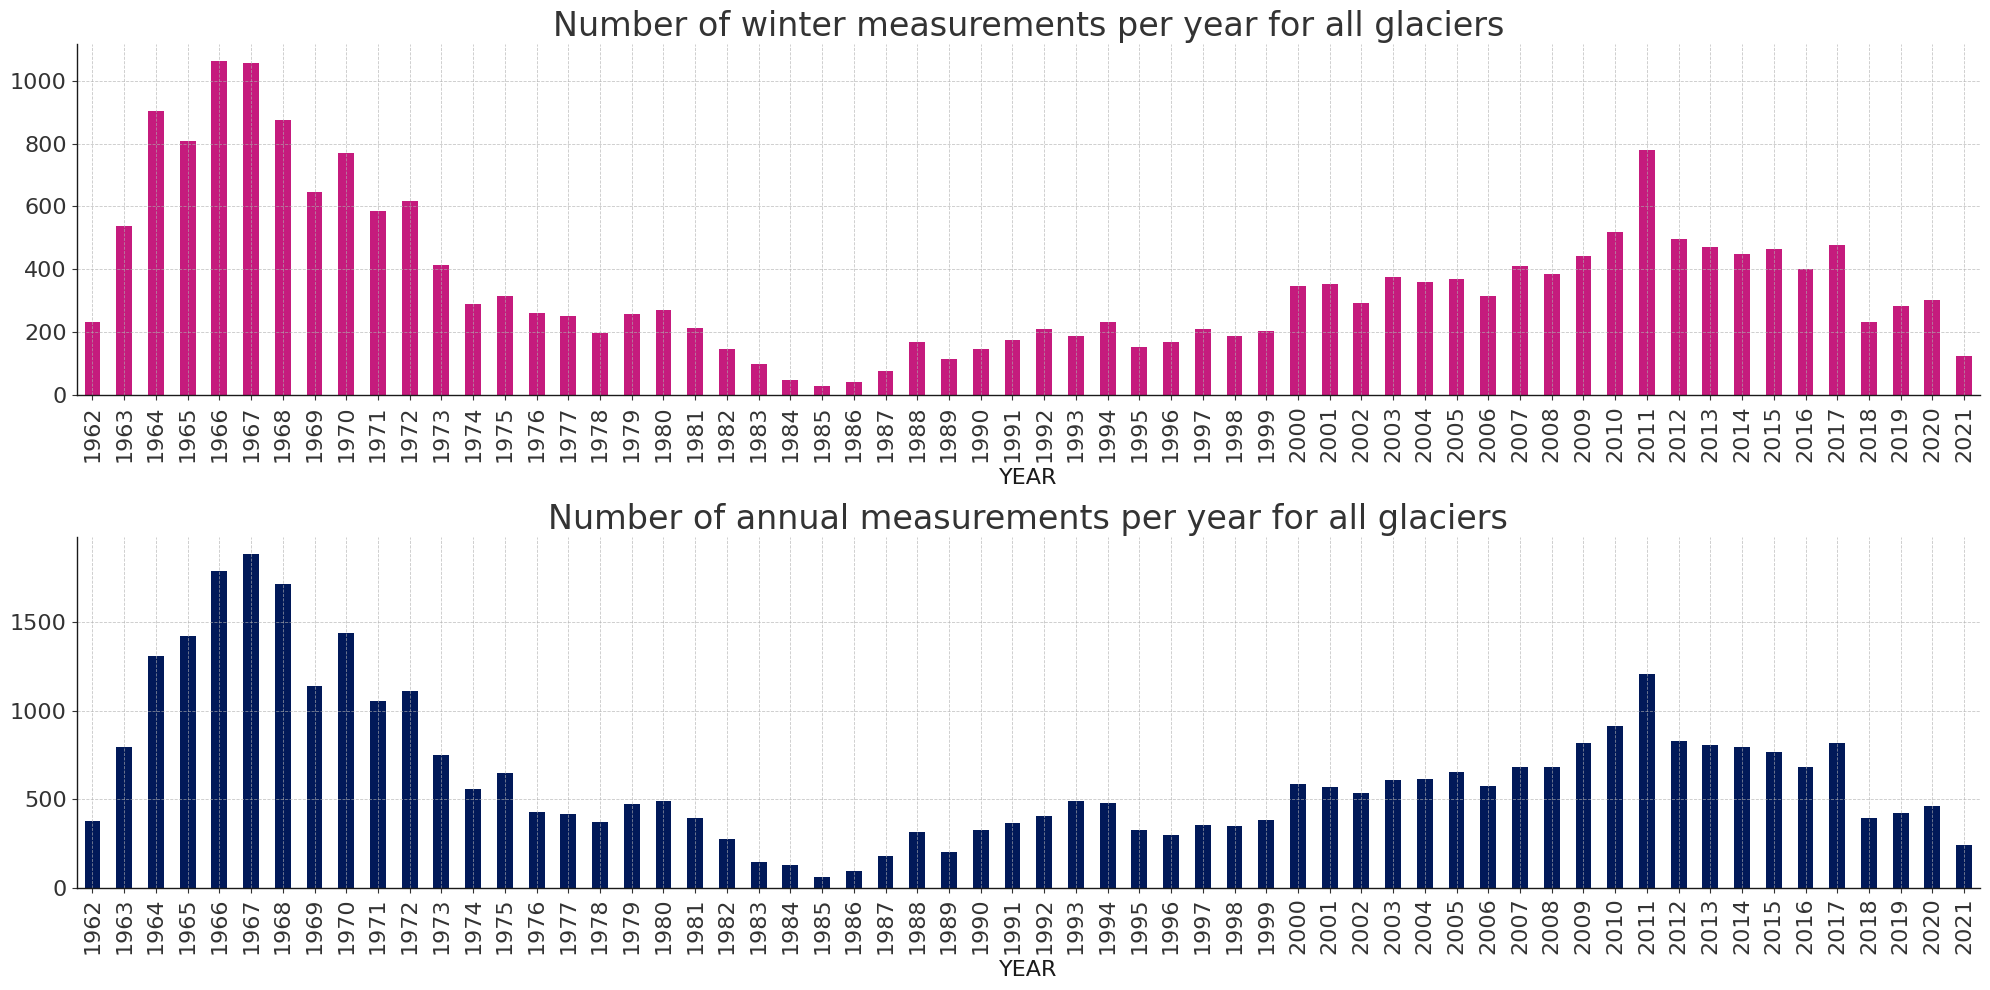

In [7]:
# Number of measurements per year:
dataloader_gl.data.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

# Plot winter and annual separately:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharey=False)
dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              ax=axs[0],
                                              color=[color_pink],
                                              legend=False)
axs[0].set_title('Number of winter measurements per year for all glaciers',
                 fontsize=24)

dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual'].groupby(
    ['YEAR', 'PERIOD']).size().unstack().plot(kind='bar',
                                              stacked=True,
                                              ax=axs[1],
                                              color=[color_dark_blue],
                                              legend=False)
axs[1].set_title('Number of annual measurements per year for all glaciers',
                 fontsize=24)
plt.tight_layout()

#### Sanity Check

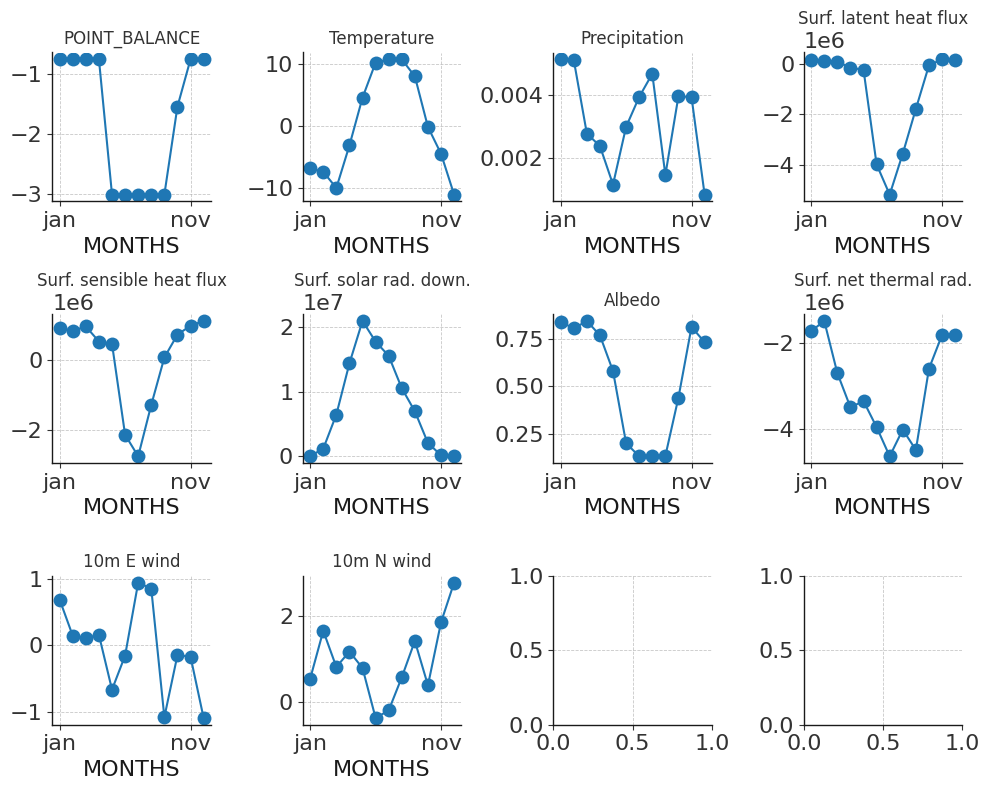

In [8]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Langfjordjoekulen') & (df.YEAR == 2013)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

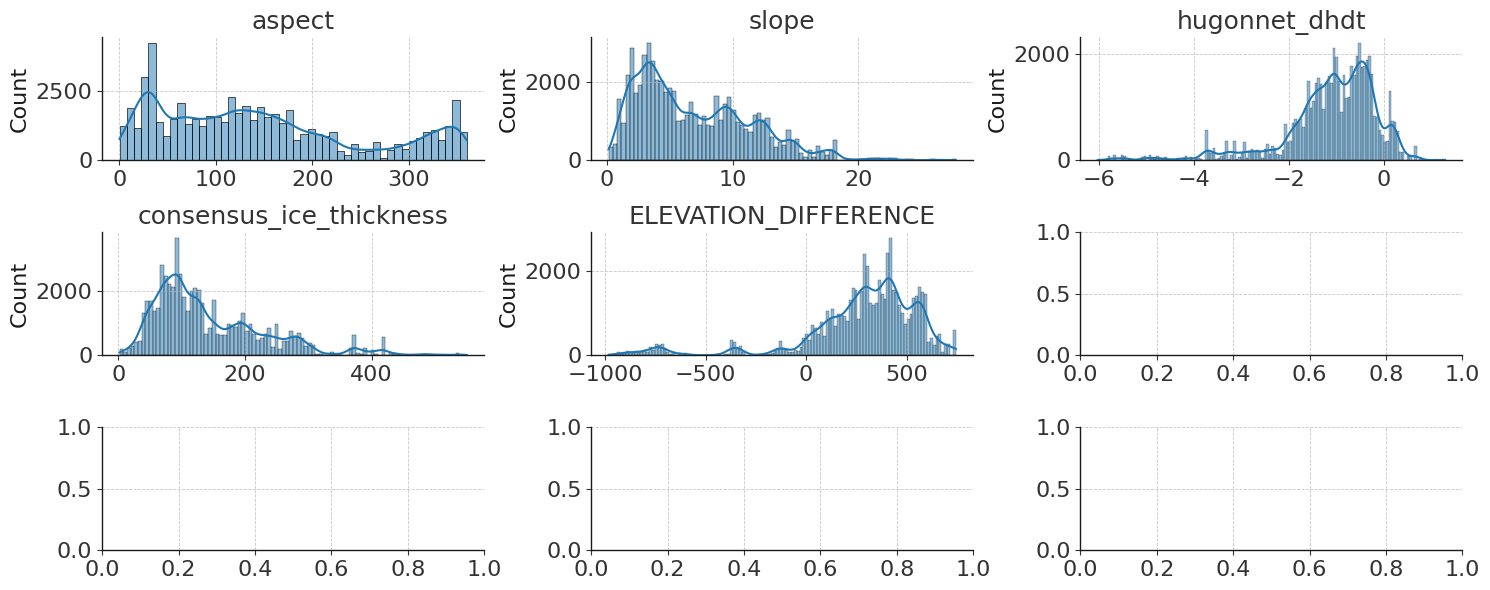

In [9]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [10]:
display(df['GLACIER'].unique())

# Remove summer stakes
dataloader_gl.data = dataloader_gl.data[dataloader_gl.data['PERIOD'] != 'summer']
dataloader_gl.data = dataloader_gl.data.reset_index(drop=True)
data_monthly = dataloader_gl.data

display(dataloader_gl.data['PERIOD'].unique())
display(data_monthly['PERIOD'].unique())

array(['Langfjordjoekulen', 'Blaaisen', 'Storsteinsfjellbreen',
       'Cainhavarre', 'Rundvassbreen', 'Storglombreen N', 'Engabreen',
       'Svartisheibreen', 'Hoegtuvbreen', 'Trollbergdalsbreen',
       'Aalfotbreen', 'Hansebreen', 'Vetlefjordbreen', 'Nigardsbreen',
       'Tunsbergdalsbreen', 'Vesledalsbreen', 'Austdalsbreen',
       'Harbardsbreen', 'Juvfonne', 'Graasubreen', 'Hellstugubreen',
       'Austre Memurubreen', 'Vestre Memurubreen', 'Rembesdalskaaka',
       'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
       'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
       'Blomstoelskardsbreen'], dtype=object)

array(['annual', 'winter'], dtype=object)

array(['annual', 'winter'], dtype=object)

#### Spatial Distribution

In [12]:
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 10239
Size of train data: 50026
Percentage of test size: 20.47%
Train:
Number of winter and annual samples: 50026
Number of annual samples: 31922
Number of winter samples: 18104
Test:
Number of winter and annual samples: 10239
Number of annual samples: 6505
Number of winter samples: 3734
Total:
Number of monthly rows: 60265
Number of annual rows: 38427
Number of winter rows: 21838


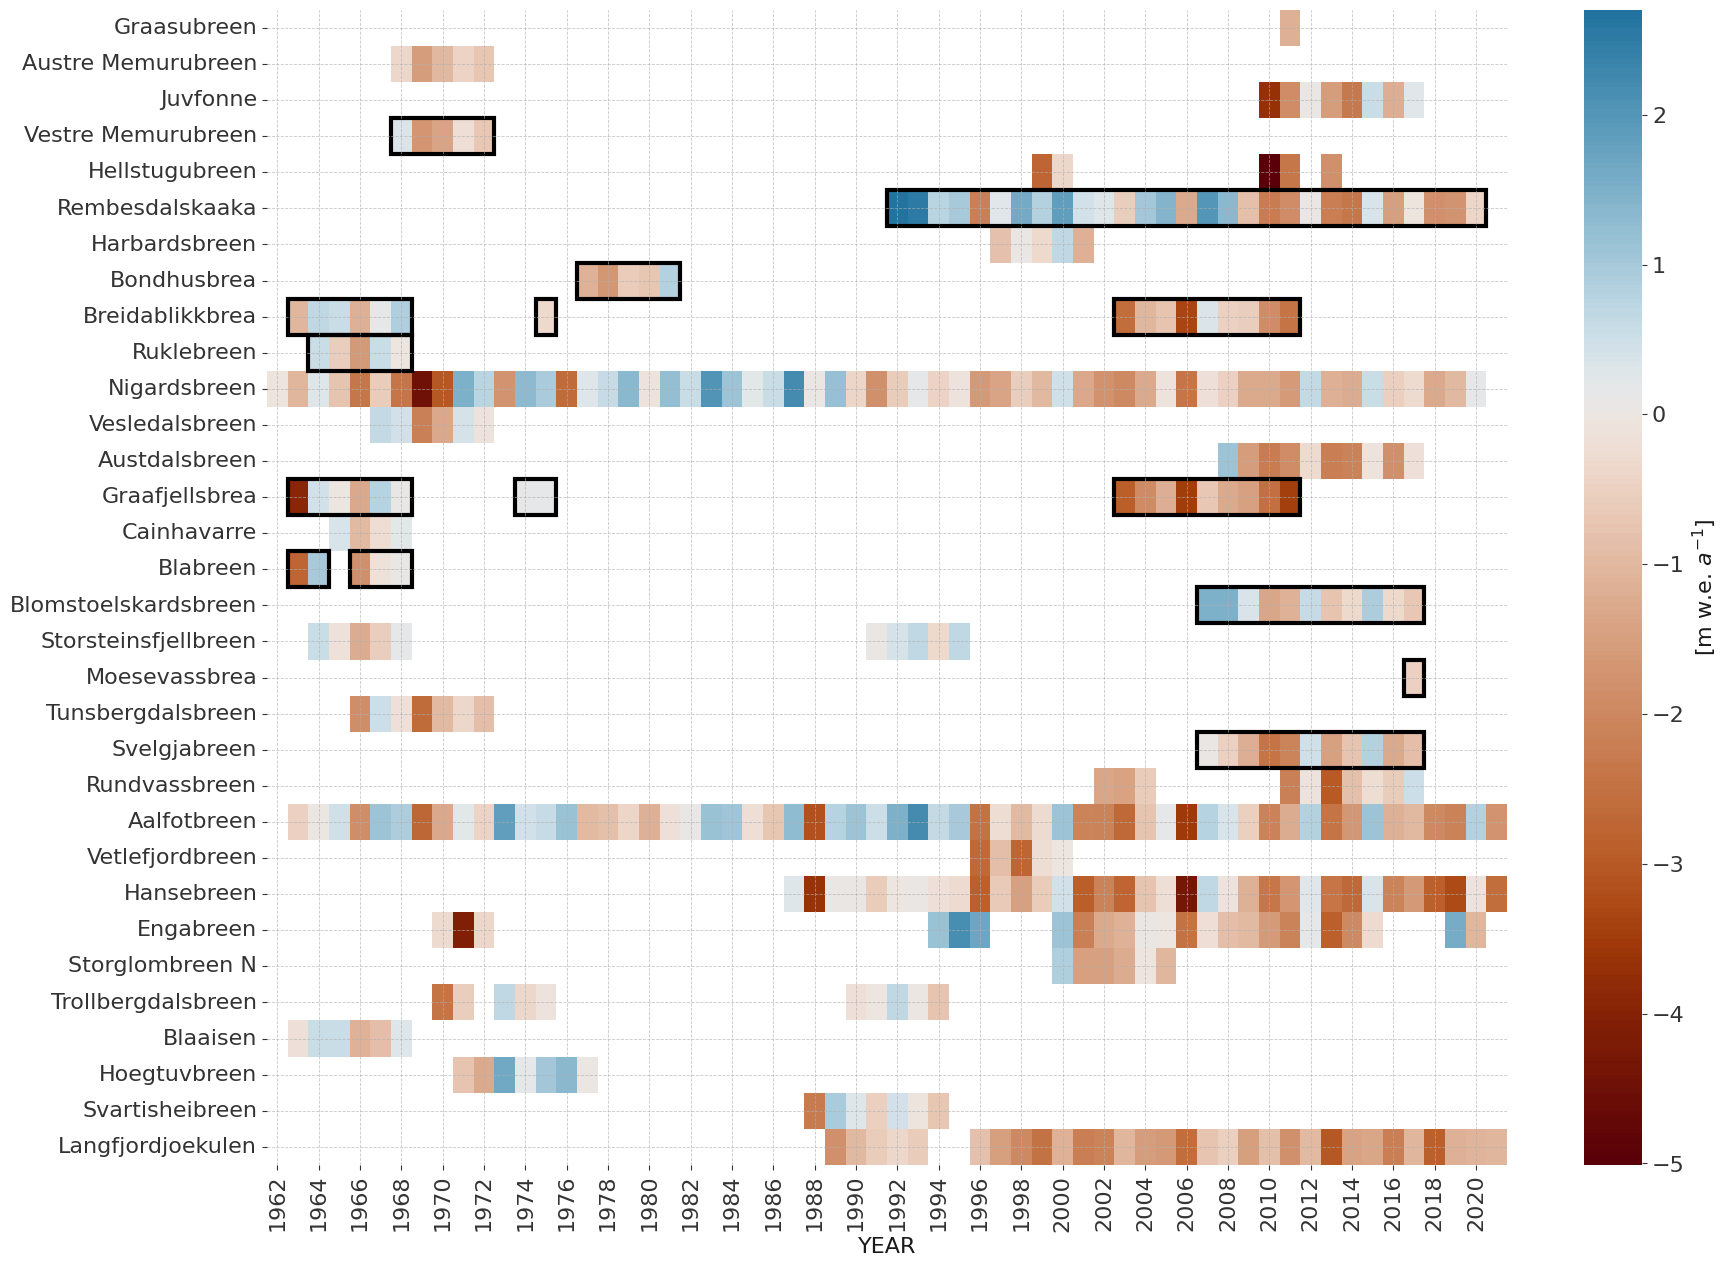

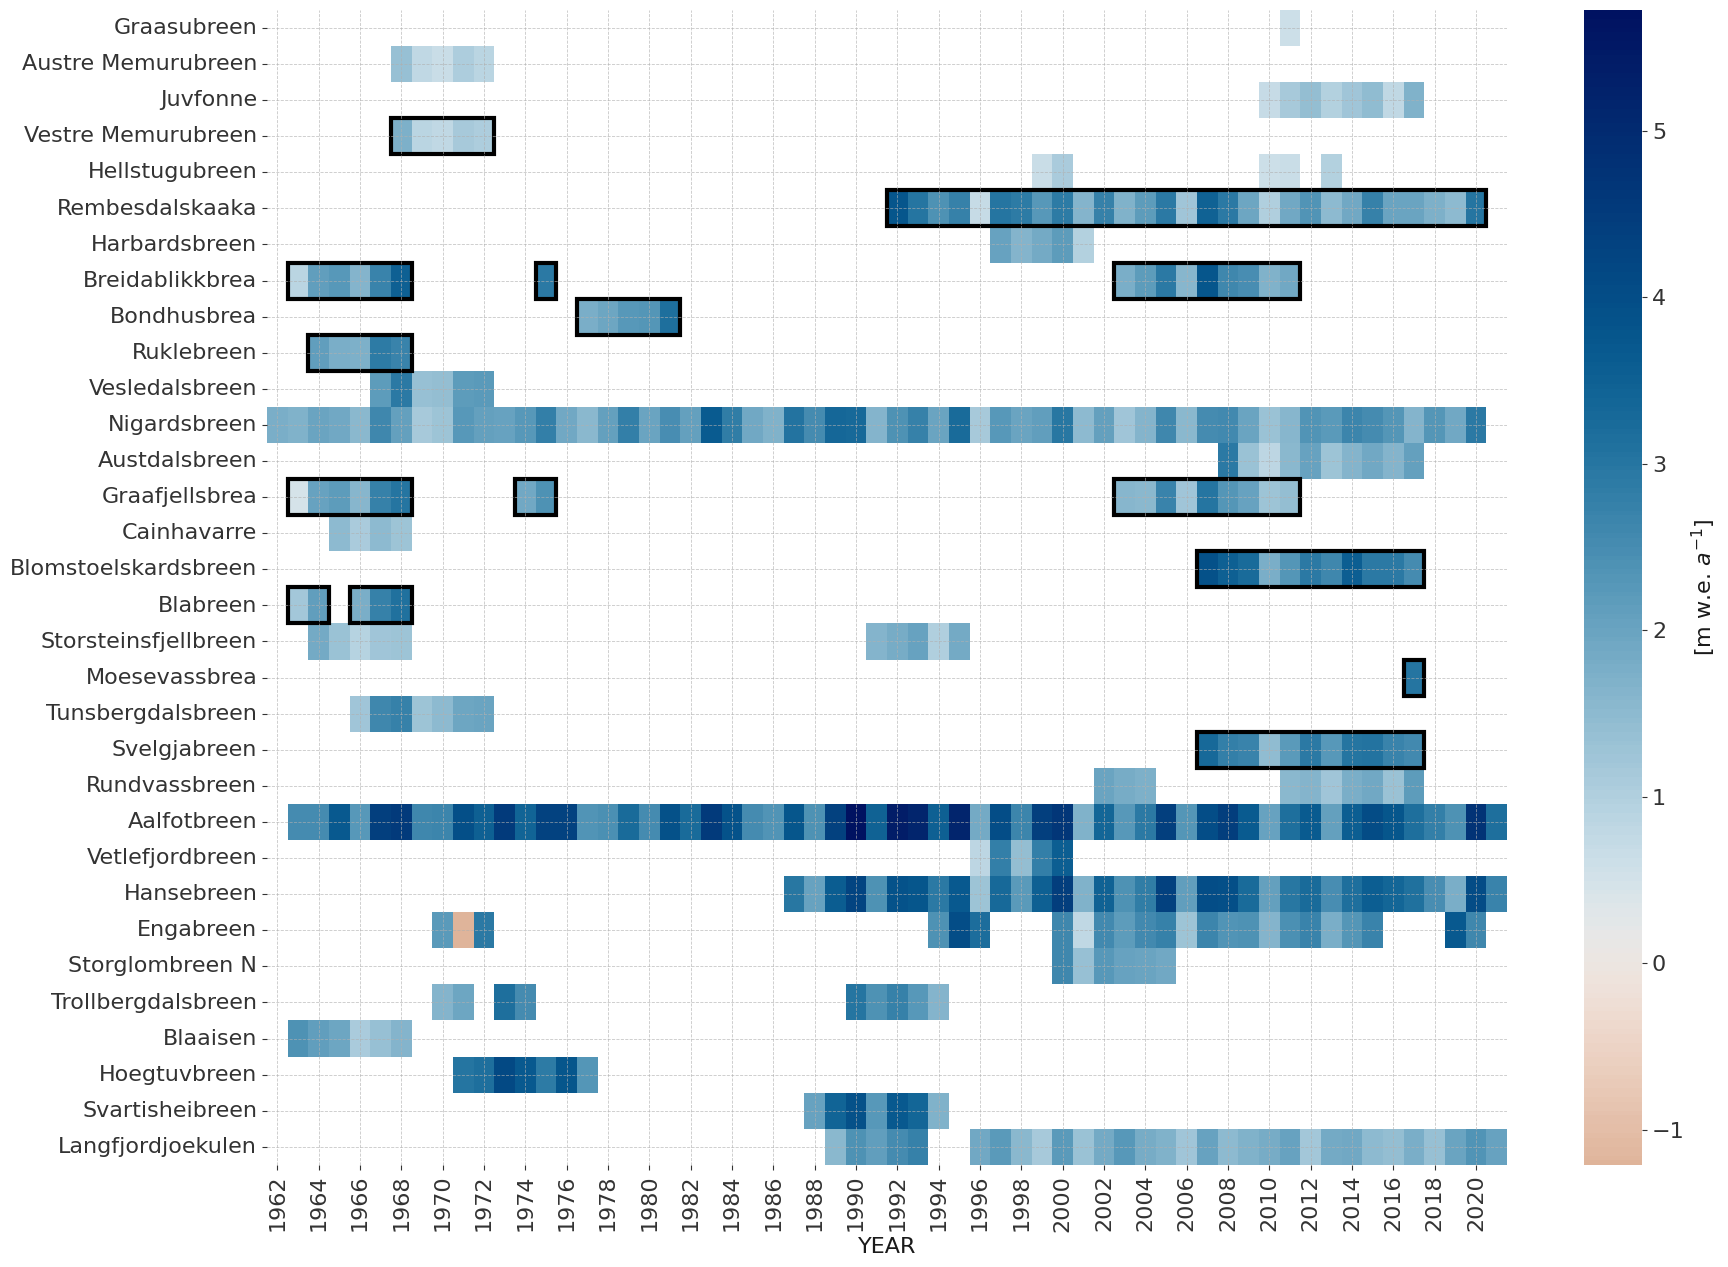

In [13]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

In [26]:
display(test_set)

{'df_X':        YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
 31922  1969    8.48990   61.53033          -1.84       1612.752749   
 31923  1969    8.48990   61.53033          -1.84       1612.752749   
 31924  1969    8.48990   61.53033          -1.84       1612.752749   
 31925  1969    8.48990   61.53033          -1.84       1612.752749   
 31926  1969    8.48990   61.53033          -1.84       1612.752749   
 ...     ...        ...        ...            ...               ...   
 60260  2017    6.34738   59.93791           1.15        917.733158   
 60261  2017    6.34738   59.93791           1.15        917.733158   
 60262  2017    6.34738   59.93791           1.15        917.733158   
 60263  2017    6.34738   59.93791           1.15        917.733158   
 60264  2017    6.34738   59.93791           1.15        917.733158   
 
        ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
 31922            118.247251             1731  RGI60-08.00966   
 31923  

Test glaciers: (10) ['Vestre Memurubreen' 'Rembesdalskaaka' 'Blabreen' 'Graafjellsbrea'
 'Breidablikkbrea' 'Ruklebreen' 'Bondhusbrea' 'Svelgjabreen'
 'Moesevassbrea' 'Blomstoelskardsbreen']
Percentage of test size: 20.47%
Size of test set: 10239
Train glaciers: (22) ['Langfjordjoekulen' 'Blaaisen' 'Storsteinsfjellbreen' 'Cainhavarre'
 'Rundvassbreen' 'Storglombreen N' 'Engabreen' 'Svartisheibreen'
 'Hoegtuvbreen' 'Trollbergdalsbreen' 'Aalfotbreen' 'Hansebreen'
 'Vetlefjordbreen' 'Nigardsbreen' 'Tunsbergdalsbreen' 'Vesledalsbreen'
 'Austdalsbreen' 'Harbardsbreen' 'Juvfonne' 'Graasubreen' 'Hellstugubreen'
 'Austre Memurubreen']
Size of train set: 50026


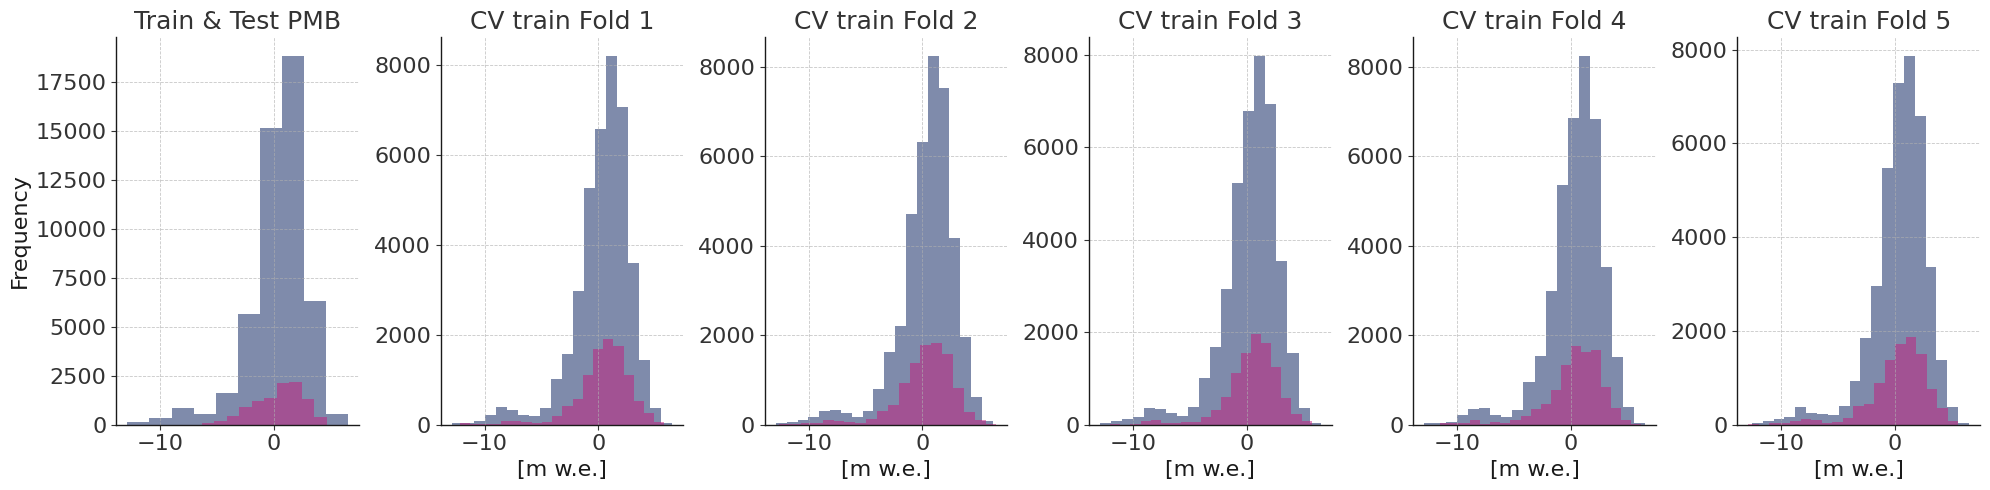

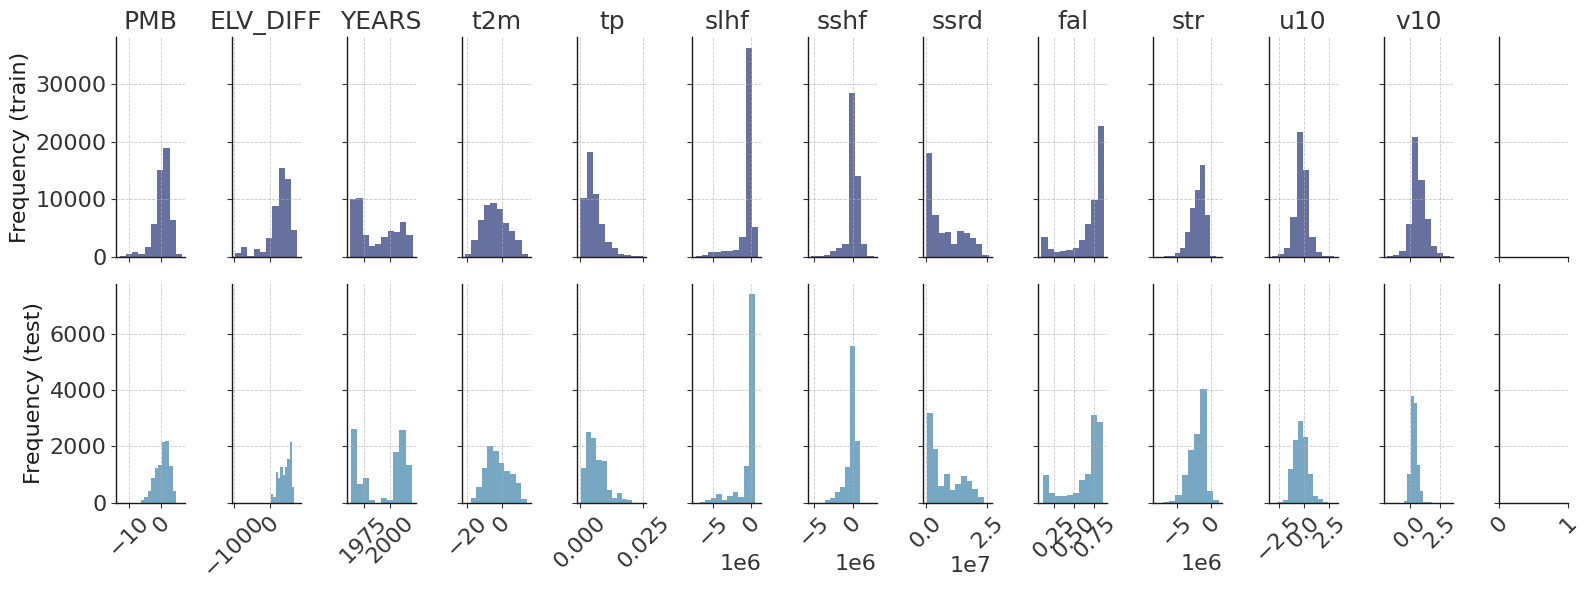

In [14]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

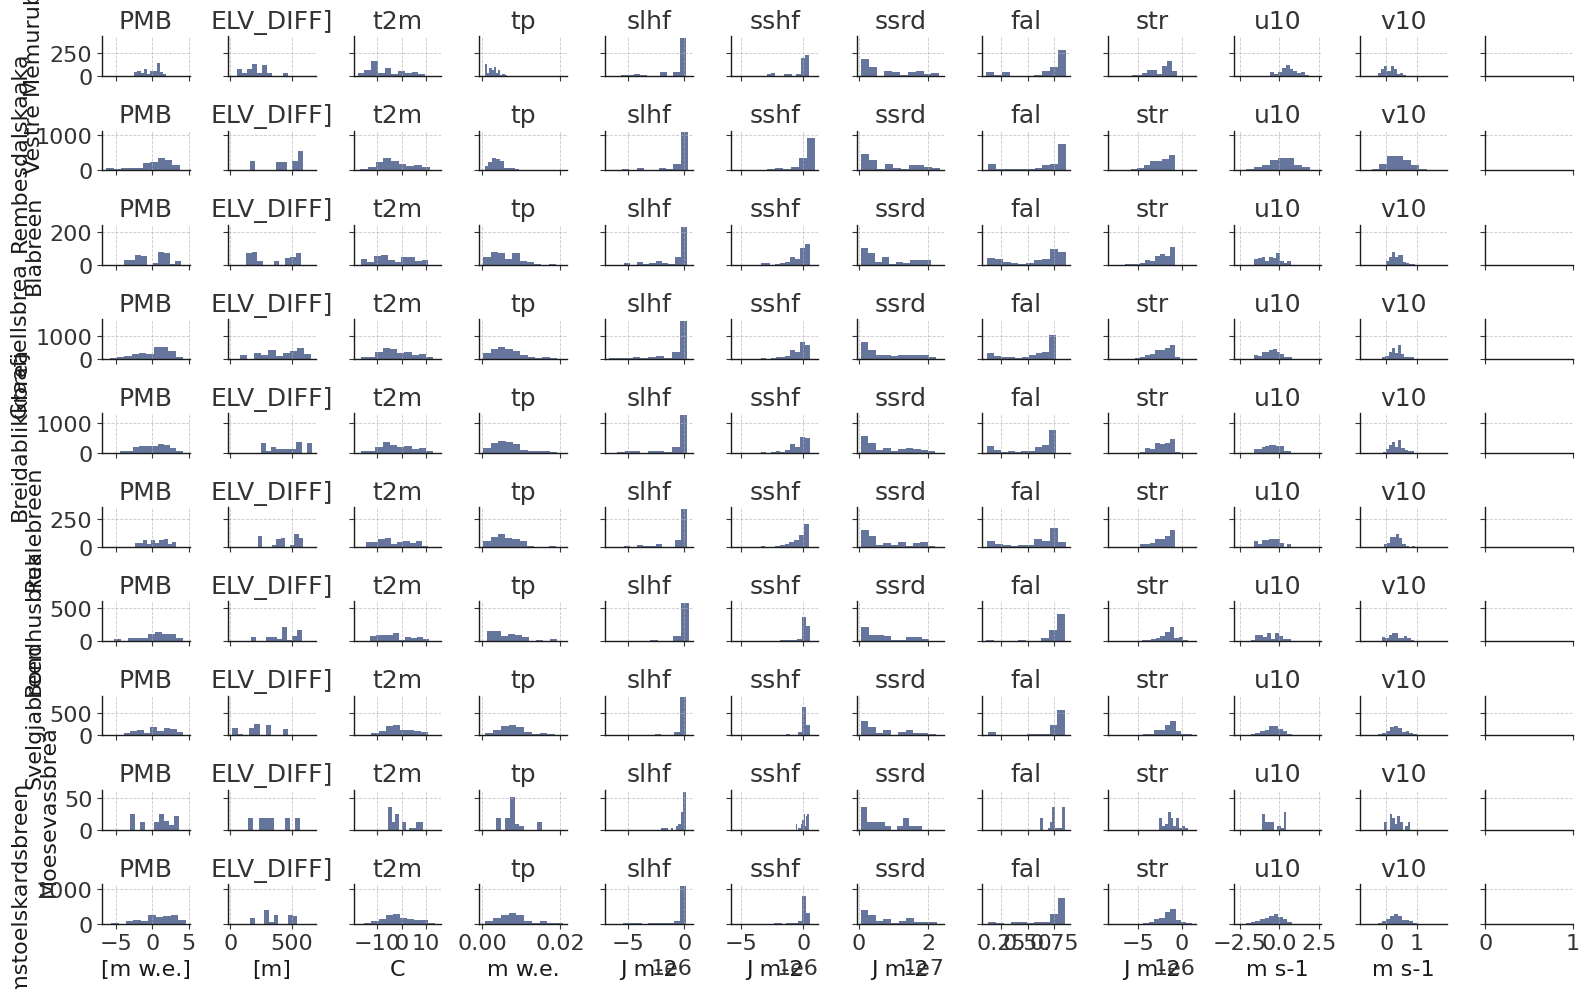

In [15]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

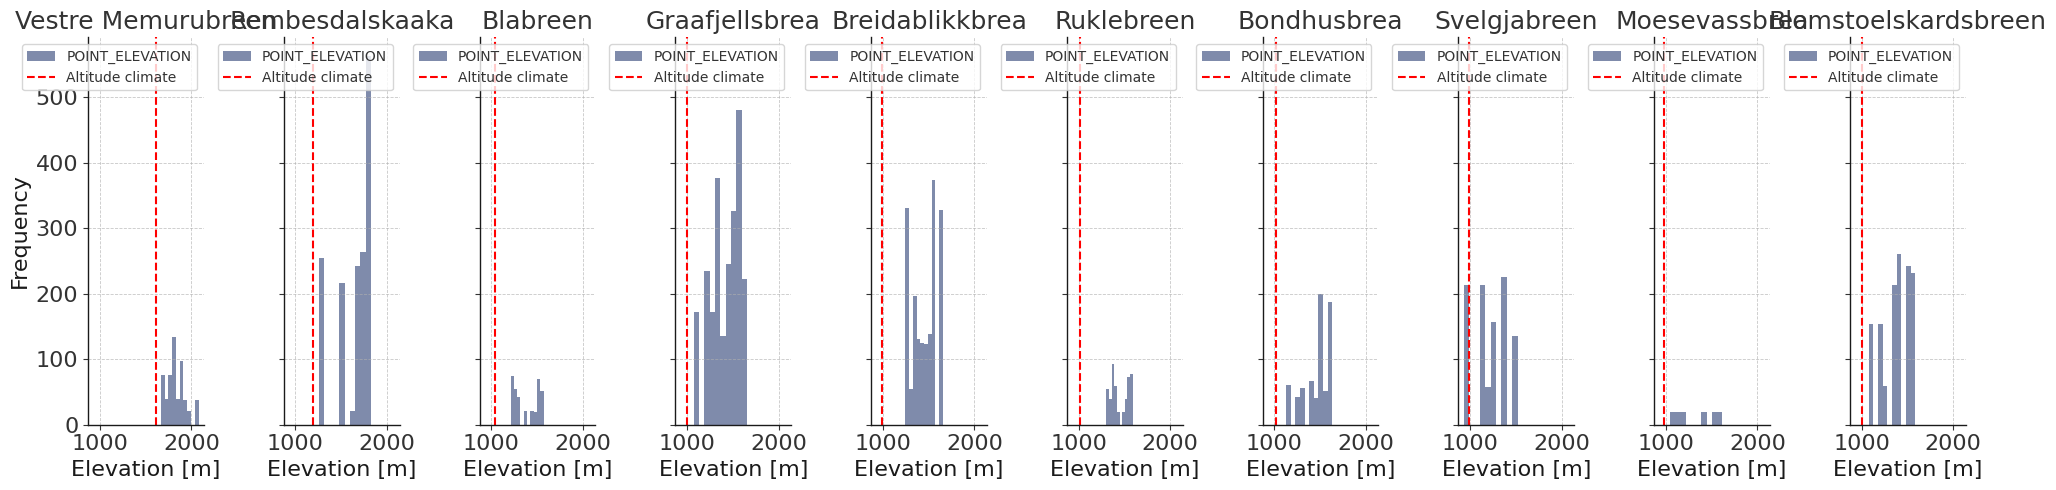

In [16]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

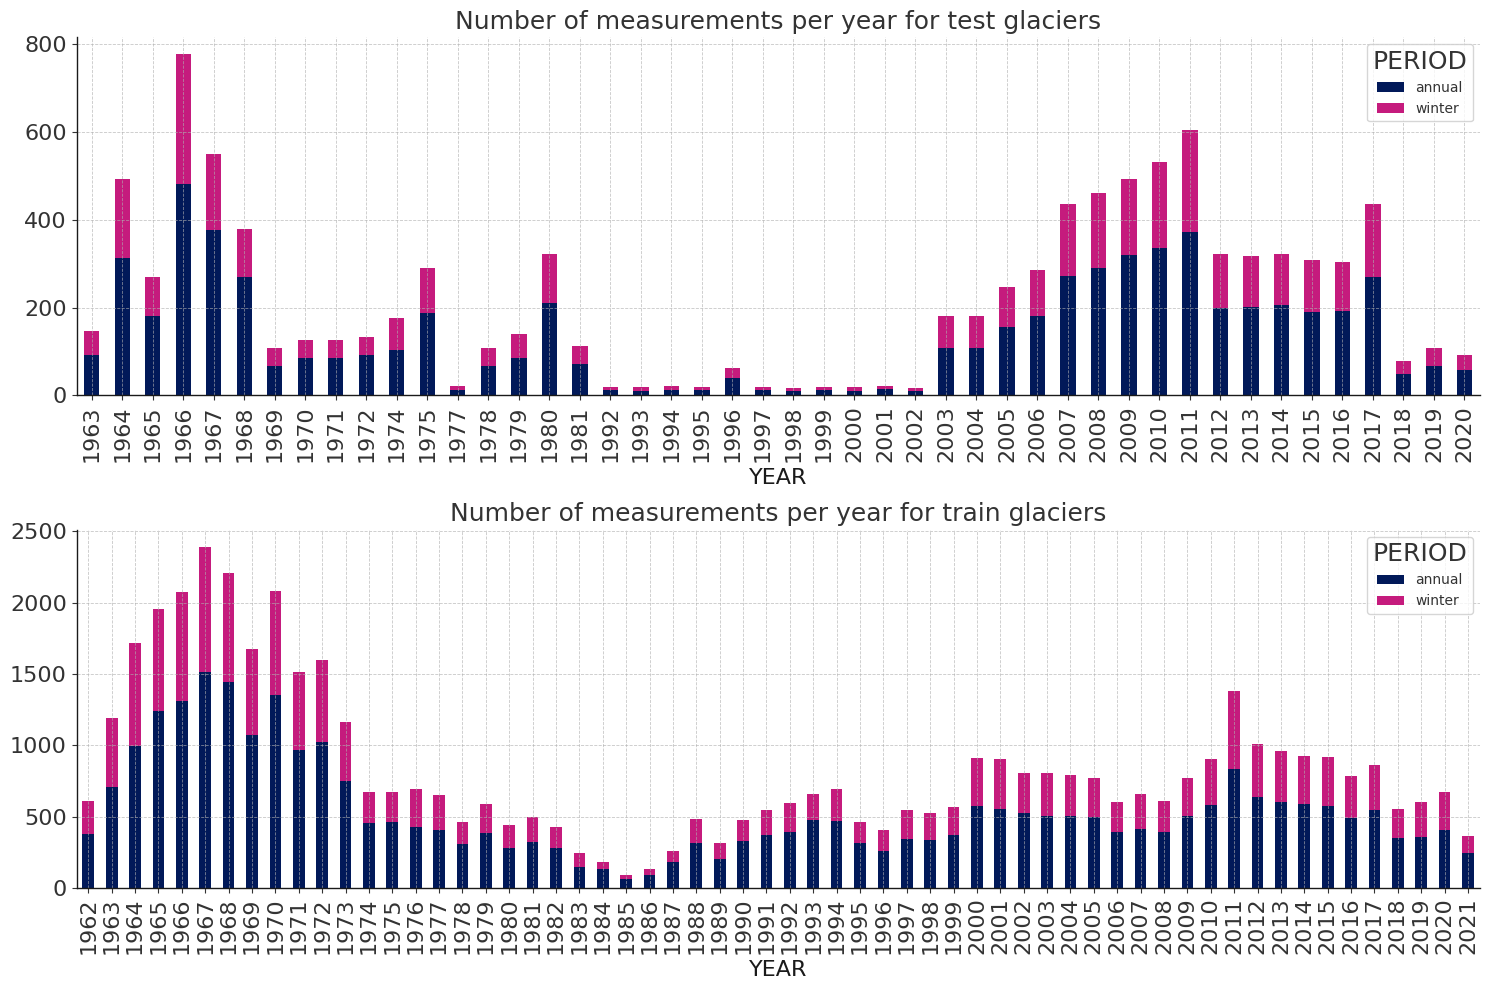

In [17]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

## XGBoost:

In [18]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

### Grid search:

In [19]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Norway.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Norway.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (50026, 25)
Shape of testing dataset: (10239, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:59:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [17:59:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.

Best parameters:
 {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.1}
Best score:
 -0.256253808455725
Shape of the test: (10239, 14)
Overall score: 0.996050433028221
CPU times: user 6min 12s, sys: 2.35 s, total: 6min 14s
Wall time: 6min 29s


In [ ]:
# visualiseValPreds(best_estimator, splits, train_set, feature_columns)

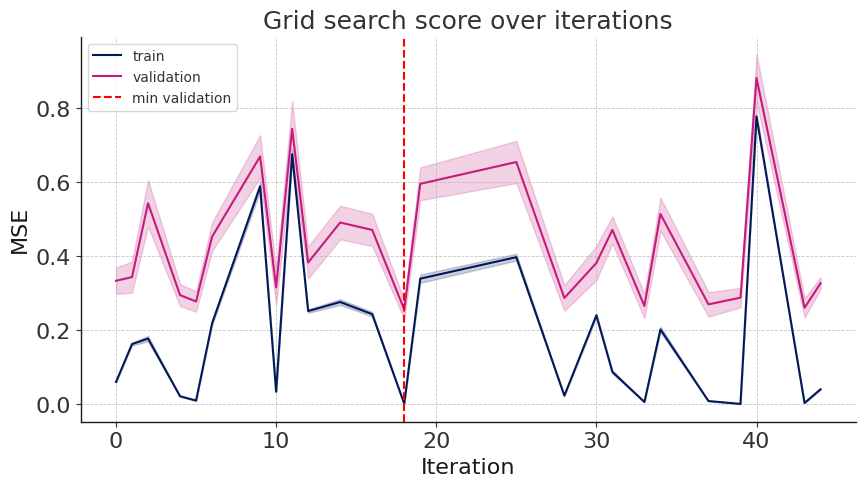

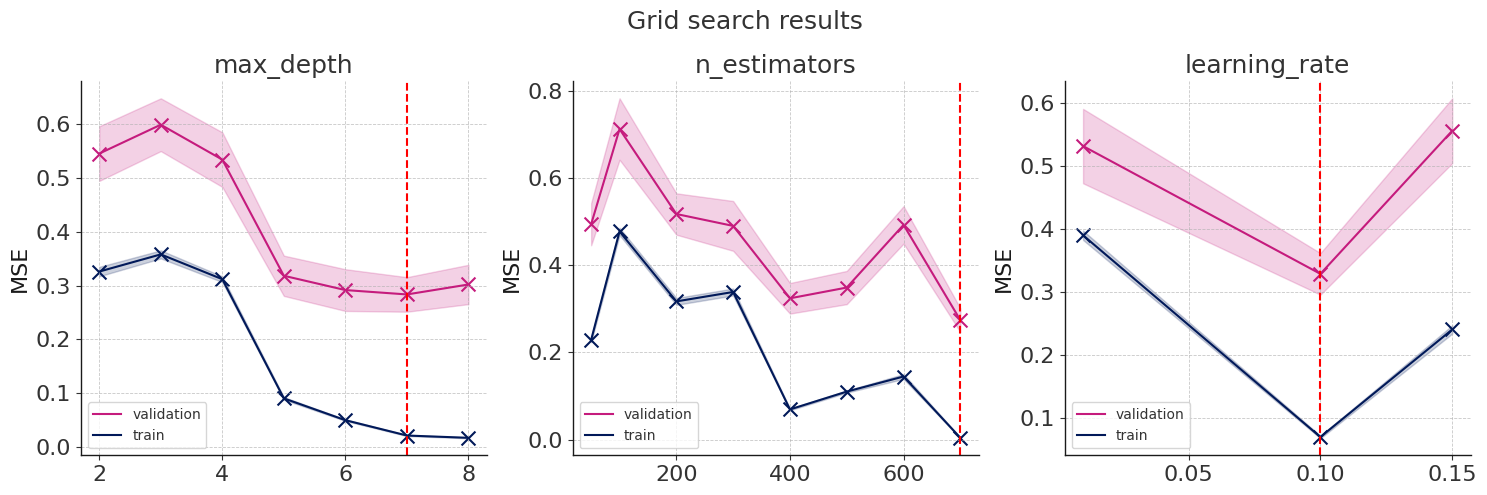

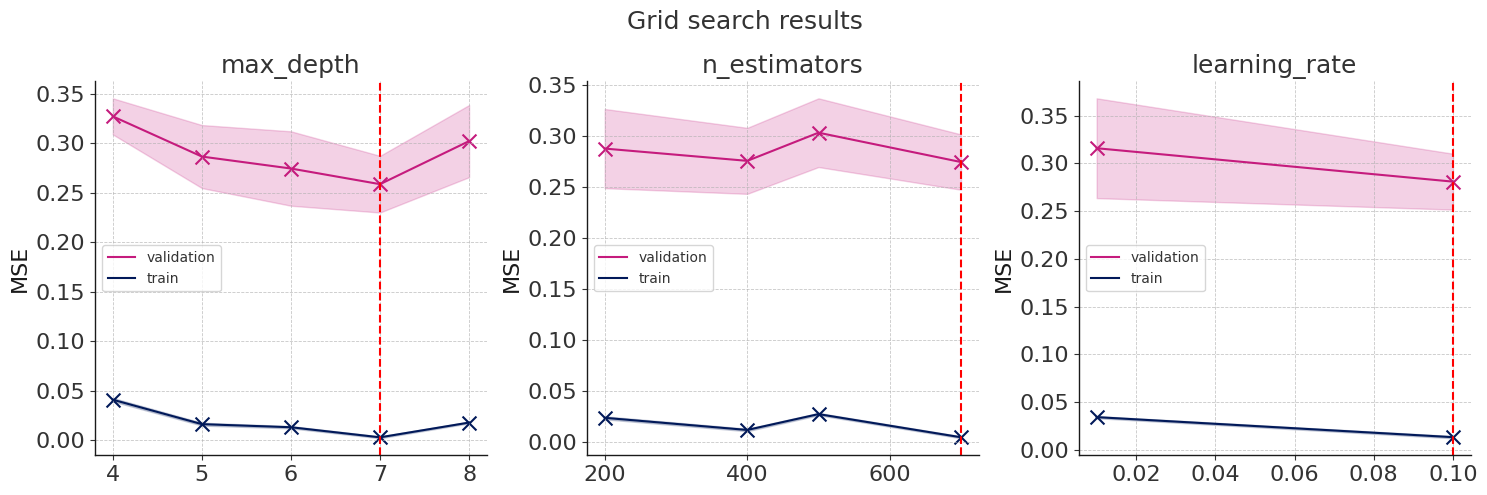

In [20]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

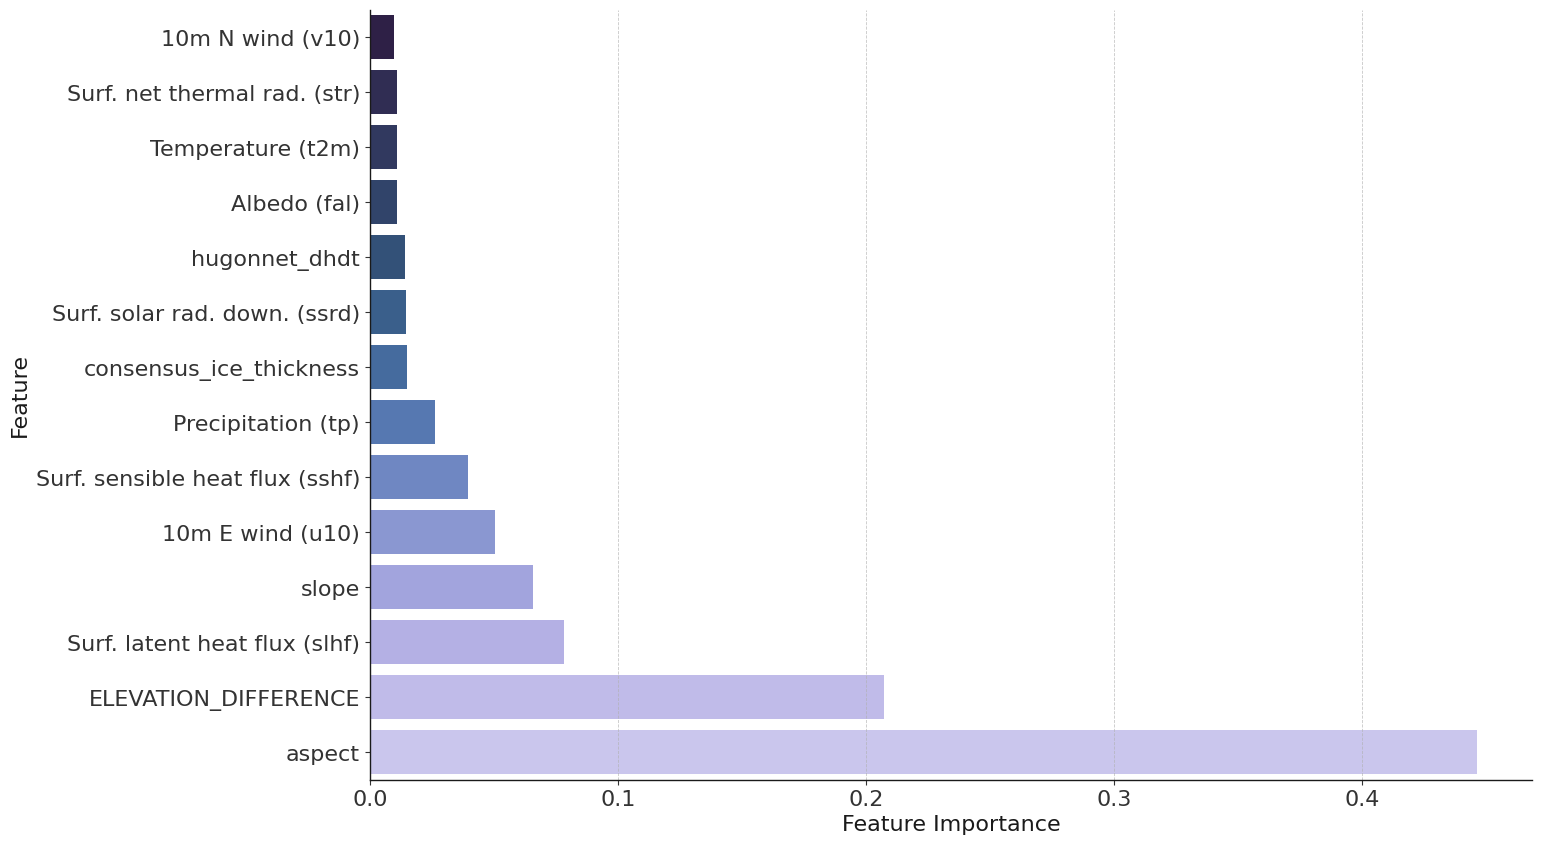

In [21]:
FIPlot(best_estimator, feature_columns, vois_climate)

#### Predictions of best parameters:

Shape of the test: (10239, 14)
{'Vestre Memurubreen': '#a6cee3', 'Rembesdalskaaka': '#1f78b4', 'Blabreen': '#b2df8a', 'Graafjellsbrea': '#33a02c', 'Breidablikkbrea': '#fb9a99', 'Ruklebreen': '#e31a1c', 'Bondhusbrea': '#fdbf6f', 'Svelgjabreen': '#ff7f00', 'Moesevassbrea': '#cab2d6', 'Blomstoelskardsbreen': '#6a3d9a'}


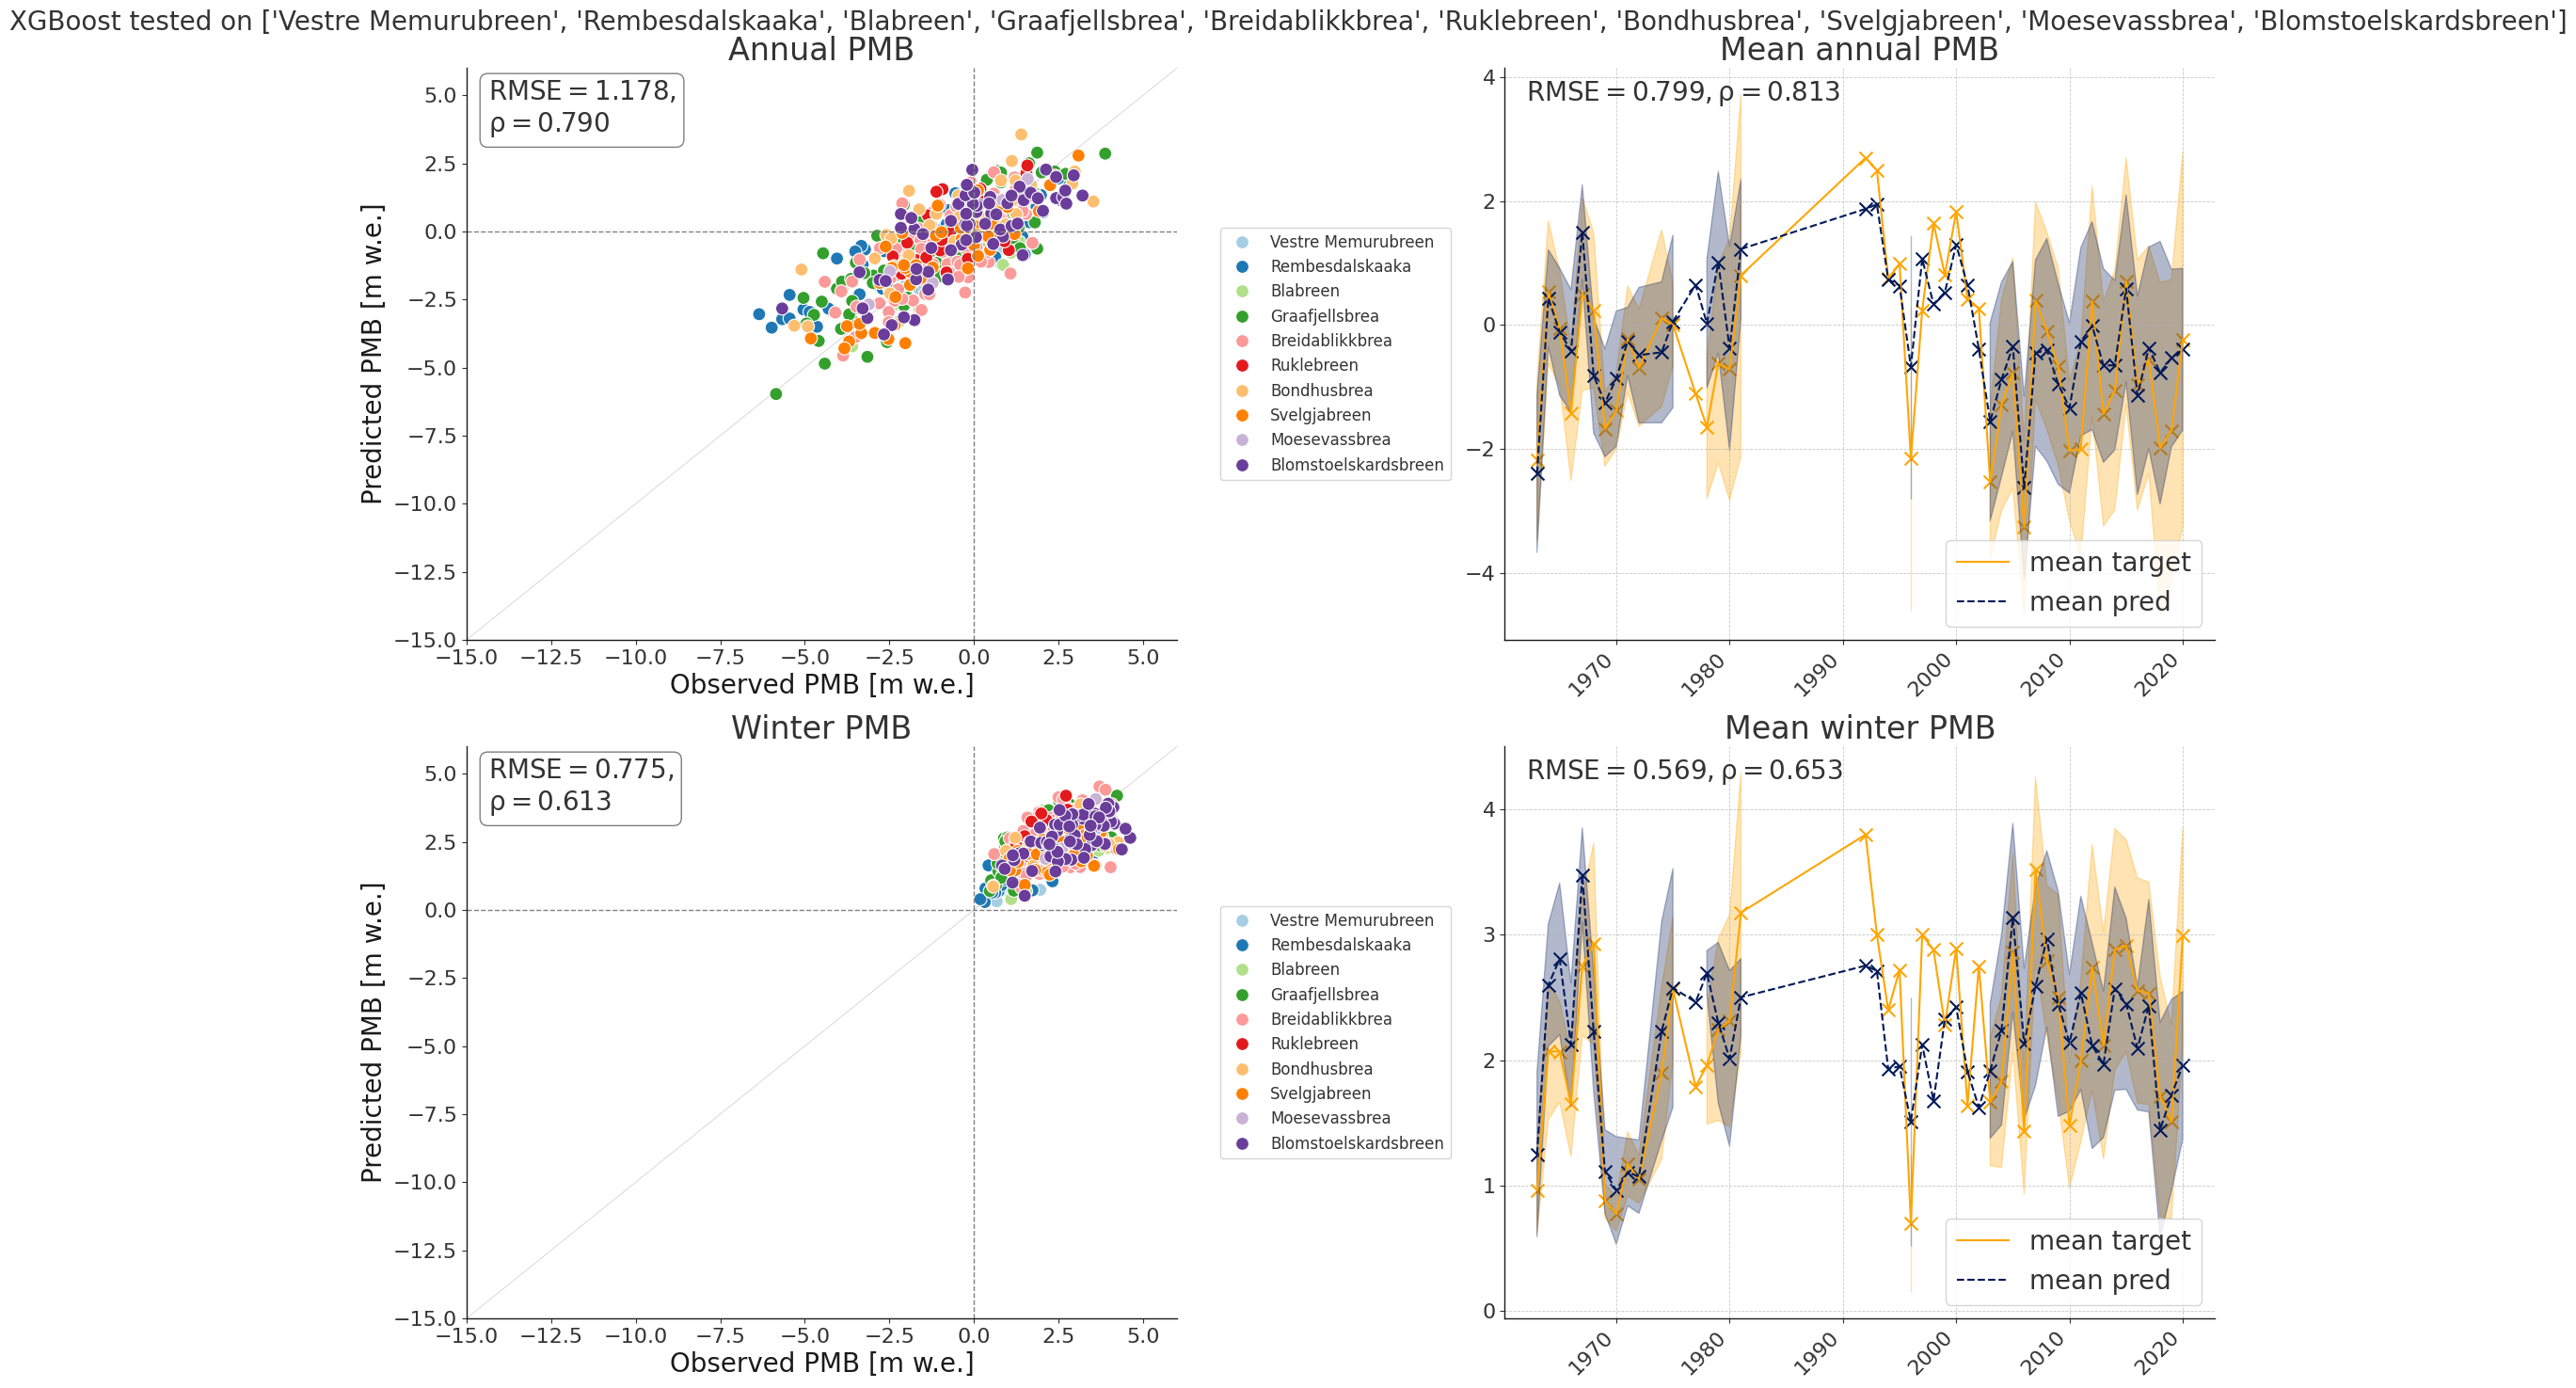

In [22]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

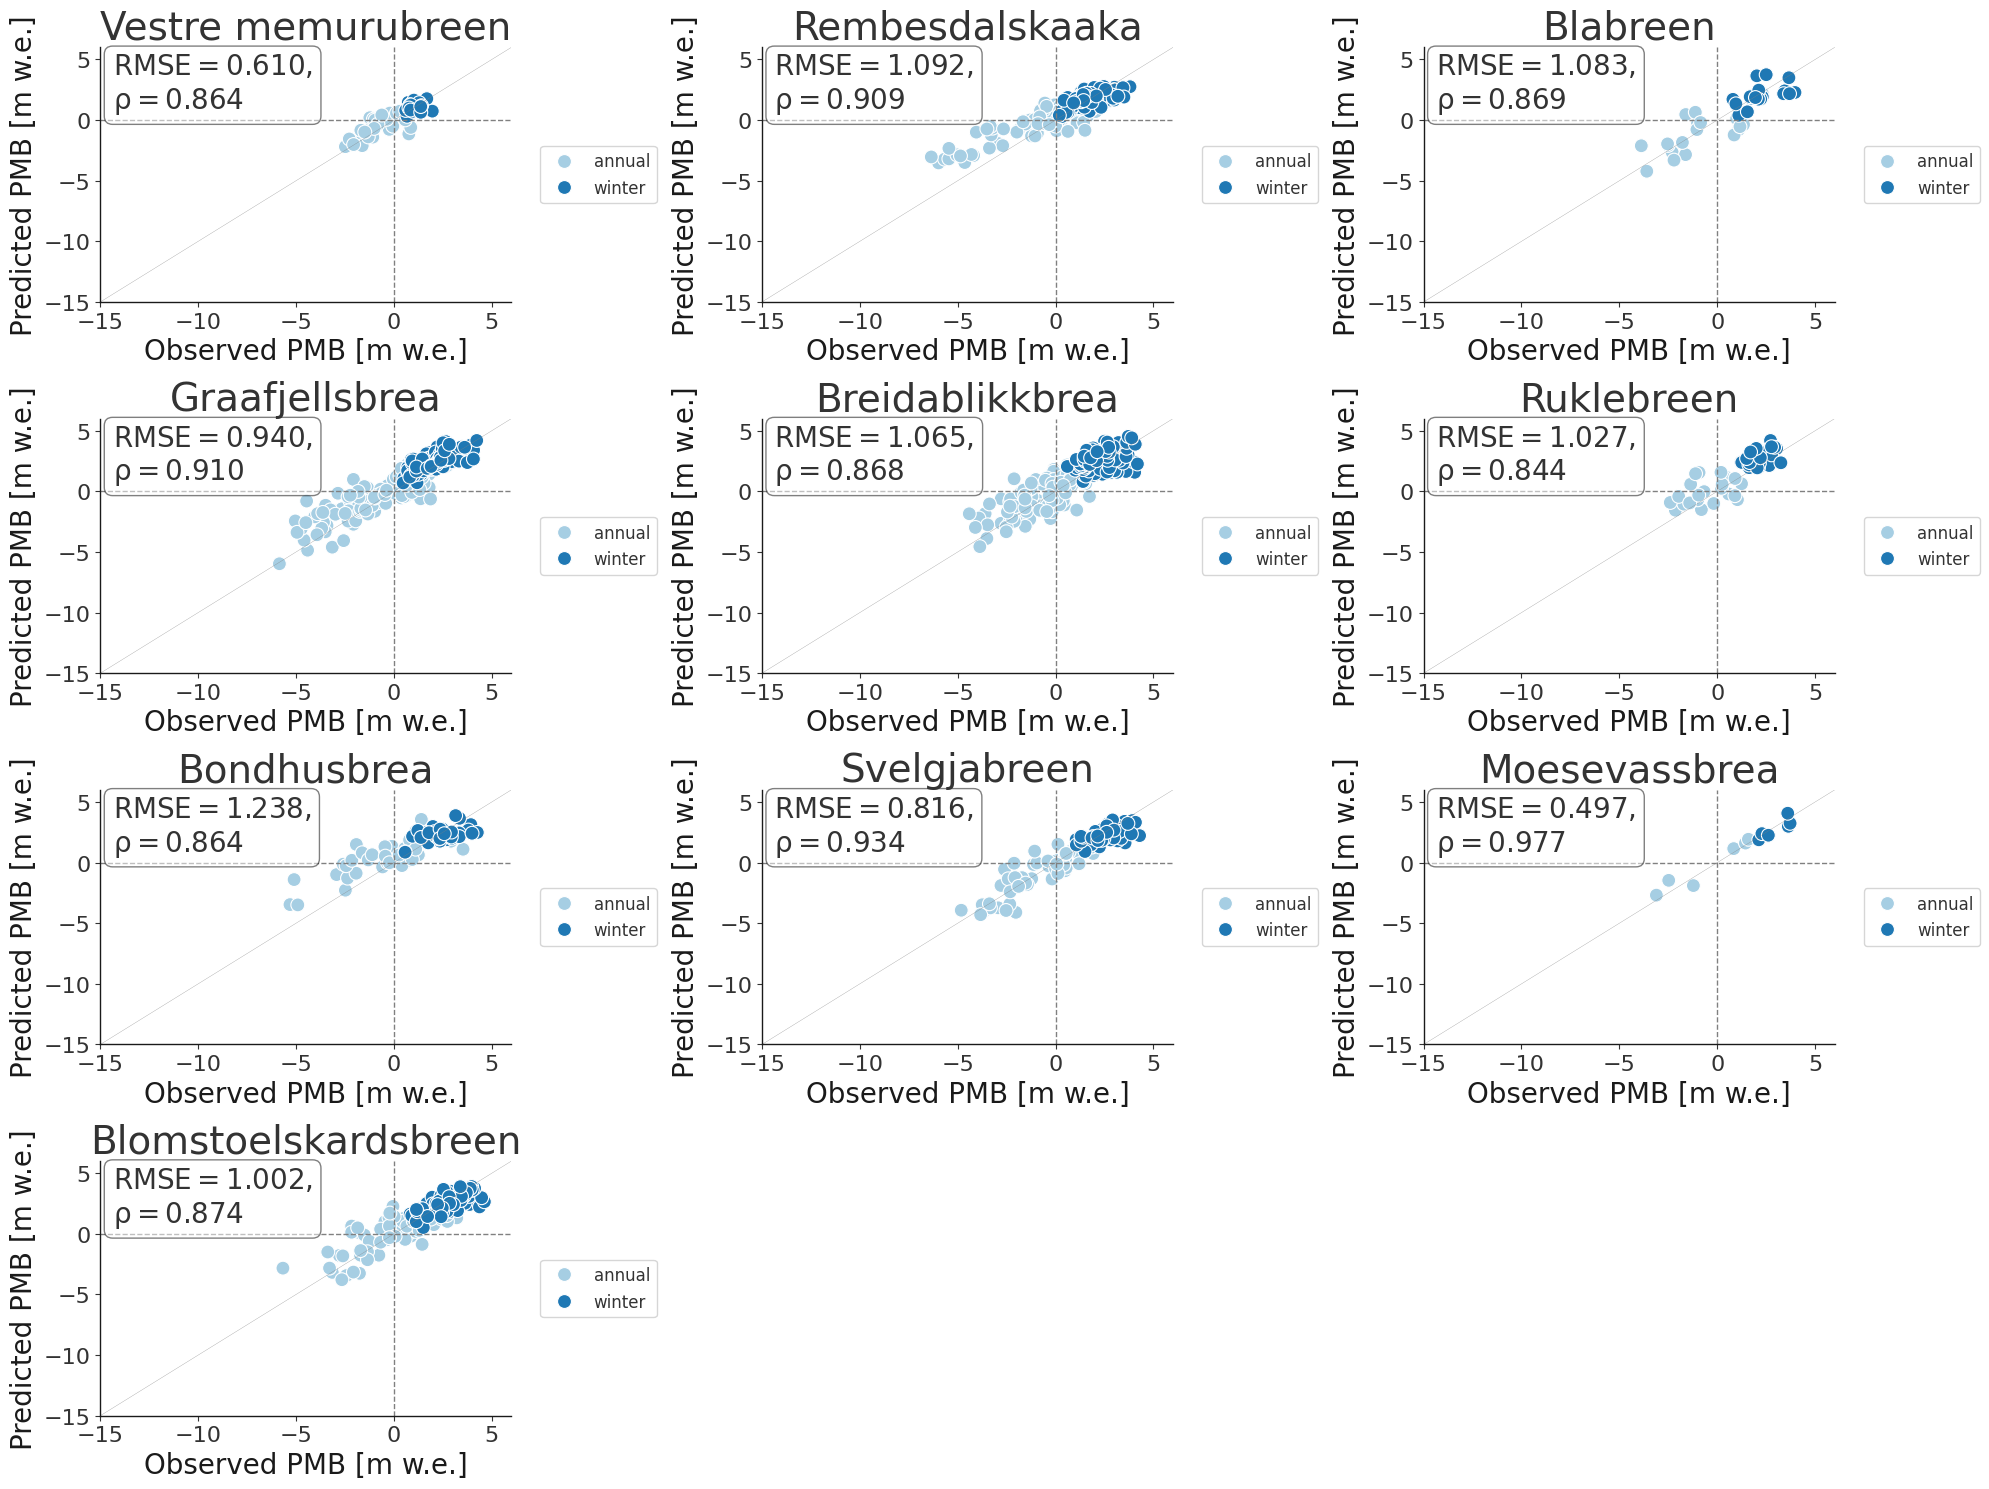

In [23]:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
display(data_monthly['GLACIER'].unique())

array(['GOLDBERG K.', 'HALLSTAETTER G.', 'HINTEREIS F.', 'JAMTAL F.',
       'KESSELWAND F.', 'KLEINFLEISS K.', 'OE. WURTEN K.', 'VENEDIGER K.',
       'VERNAGT F.', 'ZETTALUNITZ/MULLWITZ K.', 'CAMPO SETT.', 'CARESER',
       'CARESER CENTRALE', 'CARESER OCCIDENTALE', 'CARESER ORIENTALE',
       'CIARDONEY', 'FONTANA BIANCA / WEISSBRUNNF.', 'GRAND ETRET',
       'LUNGA (VEDRETTA) / LANGENF.', 'LUPO',
       'MALAVALLE (VEDR. DI) / UEBELTALF.',
       'PENDENTE (VEDR.) / HANGENDERF.',
       'RIES OCC. (VEDR. DI) / RIESERF. WESTL.', 'SURETTA MERIDIONALE'],
      dtype=object)

#### Train CH Test NOR

###### Load CH galciers and merge with IT_AT

In [ ]:
# Load CH Data into seperate dataloader

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': '/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/WGMS_all/',
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/ERA5Land/raw/era5_monthly_averaged_data.nc',
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/ERA5Land/raw/era5_geopotential_pressure.nc'
    #'radiation_save_path': path_pcsr + 'csv/'
}
RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     data_glamos=data_glamos,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'CH_wgms_dataset_monthly_full_newAPI_nopcsr.csv')
data_monthly = dataloader_gl.data

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/GLAMOS/point/csv/CH_wgms_dataset_all.csv')
data_NOR = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/Nor_dataset_all_oggm.csv')

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with IT_AT
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER', 'aspect',
       'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

In [29]:
display(data_NOR_CH.head(2))

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702            471.0   20120925  20131107          -4.92   
1   70.12578   21.77630            439.0   20131107  20140924          -2.67   

   PERIOD           RGIId  YEAR            GLACIER     aspect      slope  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen  36.073272  15.972541   
1  annual  RGI60-08.01258  2014  Langfjordjoekulen  33.570984  16.993369   

         topo  hugonnet_dhdt  consensus_ice_thickness  \
0  425.458893      -3.314563                96.980293   
1  434.652008      -2.934460                89.294670   

                          POINT_ID  
0  Langfjordjoekulen_2013_annual_0  
1  Langfjordjoekulen_2014_annual_1

In [30]:
display(data_NOR_CH['PERIOD'].unique())

array(['annual', 'winter'], dtype=object)

In [ ]:
data_CH_NOR_test = data_NOR_CH.copy()

display(data_CH_NOR_test.shape)
display(data_CH_NOR_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': path_PMB_WGMS_csv,
    'era5_climate_data': '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw/test/era5_monthly_averaged_data_CHNOR.nc',
    'geopotential_data': '/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/ERA5Land/raw/test/era5_geopotential_pressure_CHNOR.nc'
    #'radiation_save_path': path_pcsr + 'zarr/'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

(40708, 16)

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  POINT_BALANCE  \
0   70.12589   21.77702            471.0   20120925  20131107          -4.92   
1   70.12578   21.77630            439.0   20131107  20140924          -2.67   

   PERIOD           RGIId  YEAR            GLACIER     aspect      slope  \
0  annual  RGI60-08.01258  2013  Langfjordjoekulen  36.073272  15.972541   
1  annual  RGI60-08.01258  2014  Langfjordjoekulen  33.570984  16.993369   

         topo  hugonnet_dhdt  consensus_ice_thickness  \
0  425.458893      -3.314563                96.980293   
1  434.652008      -2.934460                89.294670   

                          POINT_ID  
0  Langfjordjoekulen_2013_annual_0  
1  Langfjordjoekulen_2014_annual_1

2025-05-13 21:22:55,288 - INFO - Number of annual and seasonal samples: 40708
2025-05-13 21:22:55,292 - INFO - Running on 71 glaciers:
['Langfjordjoekulen' 'Blaaisen' 'Storsteinsfjellbreen' 'Cainhavarre'
 'Rundvassbreen' 'Storglombreen N' 'Engabreen' 'Svartisheibreen'
 'Hoegtuvbreen' 'Trollbergdalsbreen' 'Aalfotbreen' 'Hansebreen'
 'Vetlefjordbreen' 'Nigardsbreen' 'Tunsbergdalsbreen' 'Vesledalsbreen'
 'Austdalsbreen' 'Harbardsbreen' 'Juvfonne' 'Graasubreen' 'Hellstugubreen'
 'Austre Memurubreen' 'Vestre Memurubreen' 'Rembesdalskaaka' 'Blabreen'
 'Graafjellsbrea' 'Breidablikkbrea' 'Ruklebreen' 'Bondhusbrea'
 'Svelgjabreen' 'Moesevassbrea' 'Blomstoelskardsbreen' 'adler' 'albigna'
 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexr

2025-05-13 21:22:55,700 - INFO - Number of winter and annual samples: 40708
2025-05-13 21:22:55,705 - INFO - Number of annual samples: 11039
2025-05-13 21:22:55,710 - INFO - Number of winter samples: 29669
2025-05-13 21:22:55,711 - INFO - Adding climate features...
2025-05-13 21:23:21,488 - INFO - Converting to monthly resolution...
2025-05-13 21:24:50,238 - INFO - Number of monthly rows: 361383
2025-05-13 21:24:50,240 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'hugonnet_dhdt', 'consensus_ice_thickness', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-05-13 21:24:56,576 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/CH_NOR_wgms_dataset_monthly_full.csv


NameError: name 'data_monthly_CH_IT_AT' is not defined

In [35]:
display(list(data_CH['GLACIER'].unique()))
display(data_CH)
display(data_NOR)

['adler',
 'albigna',
 'aletsch',
 'allalin',
 'basodino',
 'cantun',
 'chessjen',
 'clariden',
 'corbassiere',
 'corvatsch',
 'damma',
 'findelen',
 'forno',
 'gietro',
 'gorner',
 'gries',
 'hohlaub',
 'joeri',
 'limmern',
 'morteratsch',
 'murtel',
 'oberaar',
 'otemma',
 'pizol',
 'plainemorte',
 'plattalva',
 'rhone',
 'sanktanna',
 'sardona',
 'schwarzbach',
 'schwarzberg',
 'sexrouge',
 'silvretta',
 'taelliboden',
 'tiefen',
 'tortin',
 'tsanfleuron',
 'vorab',
 'witenwasseren']

YEAR         POINT_ID        GLACIER  FROM_DATE   TO_DATE  POINT_LAT  \
0      2006         adler_28          adler   20051017  20061011  46.010637   
1      2006         adler_54          adler   20051017  20061011  46.010052   
2      2006         adler_97          adler   20051017  20061011  46.010646   
3      2007         adler_28          adler   20061011  20071009  46.010602   
4      2007         adler_54          adler   20061011  20071009  46.010169   
...     ...              ...            ...        ...       ...        ...   
34406  2015          vorab_1          vorab   20141009  20151010  46.880313   
34407  2016          vorab_1          vorab   20151010  20160823  46.880313   
34408  2003  witenwasseren_2  witenwasseren   20021004  20030816  46.540533   
34409  2003  witenwasseren_0  witenwasseren   20021004  20030816  46.536711   
34410  2003  witenwasseren_1  witenwasseren   20021004  20030816  46.535284   

       POINT_LON  POINT_ELEVATION  POINT_BALANCE  PERIOD           RGIId  \
0       7.855896      3096.507742         -2.592  annual  RGI60-11.02764   
1       7.858628      3141.506520         -2.502  annual  RGI60-11.02764   
2       7.860957      3191.502735         -2.592  annual  RGI60-11.02764   
3       7.855728      3093.507997         -2.250  annual  RGI60-11.02764   
4       7.858461      3124.506390         -1.836  annual  RGI60-11.02764   
...          ...              ...            ...     ...             ...   
34406   9.172743      2719.029662         -1.980  annual  RGI60-11.00752   
34407   9.172743      2718.029662         -1.350  annual  RGI60-11.00752   
34408   8.478626      2730.566173         -2.610  annual  RGI60-11.01522   
34409   8.476532      2673.577794         -2.151  annual  RGI60-11.01522   
34410   8.475240      2702.582638         -1.998  annual  RGI60-11.01522   

           aspect      slope    topo  hugonnet_dhdt  consensus_ice_thickness  
0      254.483669  19.483581  3039.0      -1.504815                43.181839  
1      273.466595  12.549861  3091.0      -0.970061                41.090096  
2      256.726621  17.539690  3143.0      -1.284834                61.502941  
3      252.091791  20.371982  3026.0      -1.452664                39.826572  
4      270.308916  12.221732  3084.0      -1.188978                49.265205  
...           ...        ...     ...            ...                      ...  
34406   91.984261   6.554848  2690.0      -1.459144                67.452751  
34407   91.984261   6.554848  2690.0      -1.459144                67.452751  
34408   14.338433   9.574045  2575.0      -1.626393                35.471848  
34409   14.749734   9.972176  2646.0      -1.567070                54.301399  
34410   13.441760   7.546773  2676.0      -1.891599                55.183056  

[34411 rows x 16 columns]

POINT_LAT  POINT_LON  POINT_ELEVATION  FROM_DATE   TO_DATE  \
0      70.12589   21.77702              471   20120925  20131107   
1      70.12578   21.77630              439   20131107  20140924   
2      70.12573   21.77590              444   20140924  20150923   
3      70.12573   21.77590              444   20150923  20160922   
4      70.12554   21.77352              468   20160922  20170929   
...         ...        ...              ...        ...       ...   
6292   59.93803    6.34733             1078   20111001  20120503   
6293   59.93789    6.34729             1078   20121012  20130529   
6294   59.93815    6.34702             1079   20141014  20150422   
6295   59.93803    6.34724             1078   20151014  20160428   
6296   59.93791    6.34738             1078   20161006  20170502   

      POINT_BALANCE  PERIOD           RGIId  YEAR               GLACIER  \
0             -4.92  annual  RGI60-08.01258  2013     Langfjordjoekulen   
1             -2.67  annual  RGI60-08.01258  2014     Langfjordjoekulen   
2             -3.41  annual  RGI60-08.01258  2015     Langfjordjoekulen   
3             -3.59  annual  RGI60-08.01258  2016     Langfjordjoekulen   
4             -2.46  annual  RGI60-08.01258  2017     Langfjordjoekulen   
...             ...     ...             ...   ...                   ...   
6292           1.50  winter  RGI60-08.02969  2012  Blomstoelskardsbreen   
6293           1.14  winter  RGI60-08.02969  2013  Blomstoelskardsbreen   
6294           1.19  winter  RGI60-08.02969  2015  Blomstoelskardsbreen   
6295           1.72  winter  RGI60-08.02969  2016  Blomstoelskardsbreen   
6296           1.15  winter  RGI60-08.02969  2017  Blomstoelskardsbreen   

          aspect      slope         topo  hugonnet_dhdt  \
0      36.073272  15.972541   425.458893      -3.314563   
1      33.570984  16.993369   434.652008      -2.934460   
2      38.002076  17.332428   441.768280      -2.923457   
3      38.002076  17.332428   441.768280      -2.923457   
4      47.942662  17.715600   458.299377      -2.962617   
...          ...        ...          ...            ...   
6292  166.504029   7.546811  1093.000000      -1.385310   
6293  166.504029   7.546811  1093.000000      -1.385310   
6294  166.504029   7.546811  1093.000000      -1.385310   
6295  166.504029   7.546811  1093.000000      -1.385310   
6296  166.504029   7.546811  1093.000000      -1.385310   

      consensus_ice_thickness                               POINT_ID  
0                   96.980293        Langfjordjoekulen_2013_annual_0  
1                   89.294670        Langfjordjoekulen_2014_annual_1  
2                   90.894768        Langfjordjoekulen_2015_annual_2  
3                   90.894768        Langfjordjoekulen_2016_annual_3  
4                   97.562950        Langfjordjoekulen_2017_annual_4  
...                       ...                                    ...  
6292                68.130363  Blomstoelskardsbreen_2012_winter_7656  
6293                68.130363  Blomstoelskardsbreen_2013_winter_7657  
6294                68.130363  Blomstoelskardsbreen_2015_winter_7658  
6295                68.130363  Blomstoelskardsbreen_2016_winter_7659  
6296                68.130363  Blomstoelskardsbreen_2017_winter_7660  

[6297 rows x 16 columns]

In [36]:
test_glaciers = list(data_NOR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]
print('Size of test data:', len(data_test))

data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))

if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

# Number of annual versus winter measurements:
print('Train:')
print('Number of winter and annual samples:', len(data_train))
print('Number of annual samples:',
      len(data_train[data_train.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_train[data_train.PERIOD == 'winter']))

# Same for test
data_test_annual = data_test[data_test.PERIOD == 'annual']
data_test_winter = data_test[data_test.PERIOD == 'winter']

print('Test:')
print('Number of winter and annual samples:', len(data_test))
print('Number of annual samples:', len(data_test_annual))
print('Number of winter samples:', len(data_test_winter))

print('Total:')
print('Number of monthly rows:', len(dataloader_gl.data))
print('Number of annual rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'annual']))
print('Number of winter rows:',
      len(dataloader_gl.data[dataloader_gl.data.PERIOD == 'winter']))

Size of test data: 60265
Size of train data: 301118
Percentage of test size: 20.01%
Train:
Number of winter and annual samples: 301118
Number of annual samples: 93904
Number of winter samples: 207214
Test:
Number of winter and annual samples: 60265
Number of annual samples: 38427
Number of winter samples: 21838
Total:
Number of monthly rows: 361383
Number of annual rows: 132331
Number of winter rows: 229052


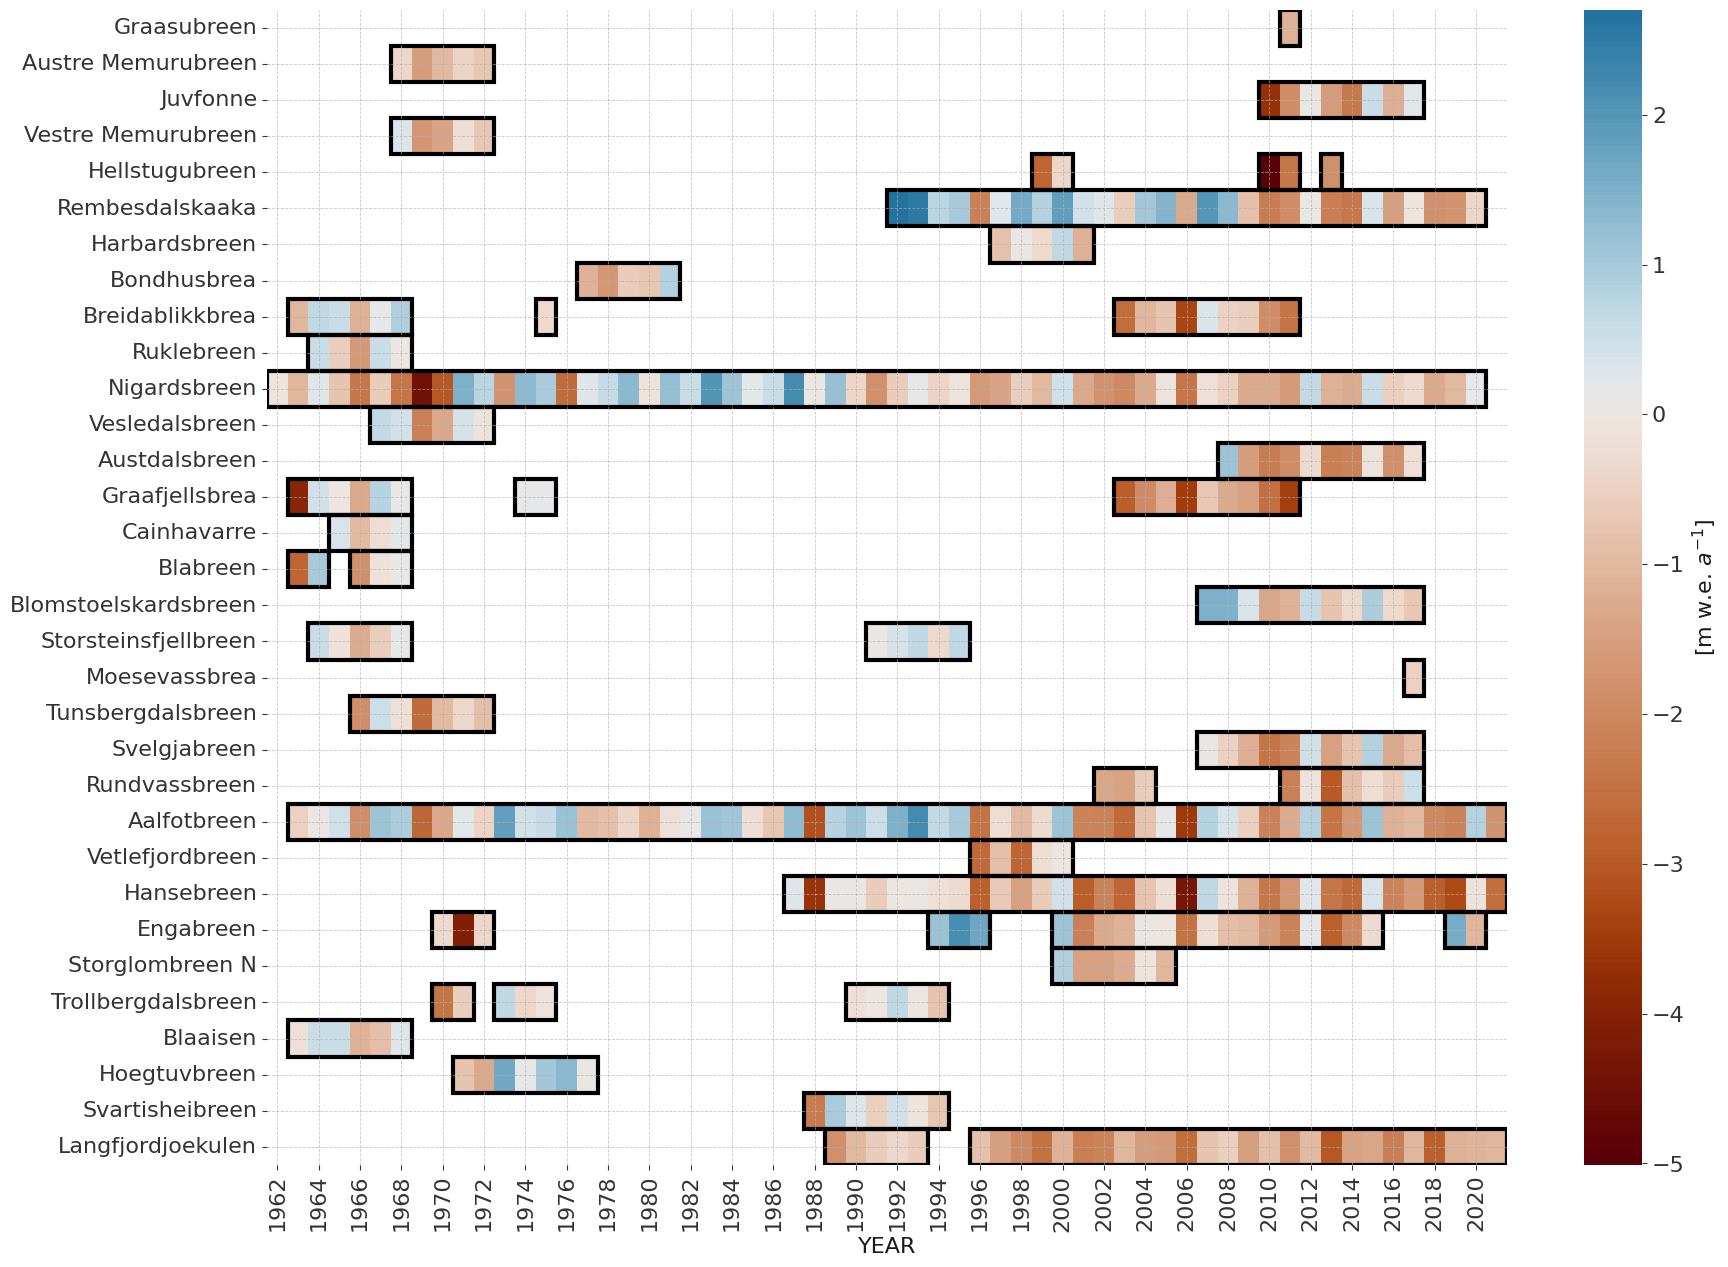

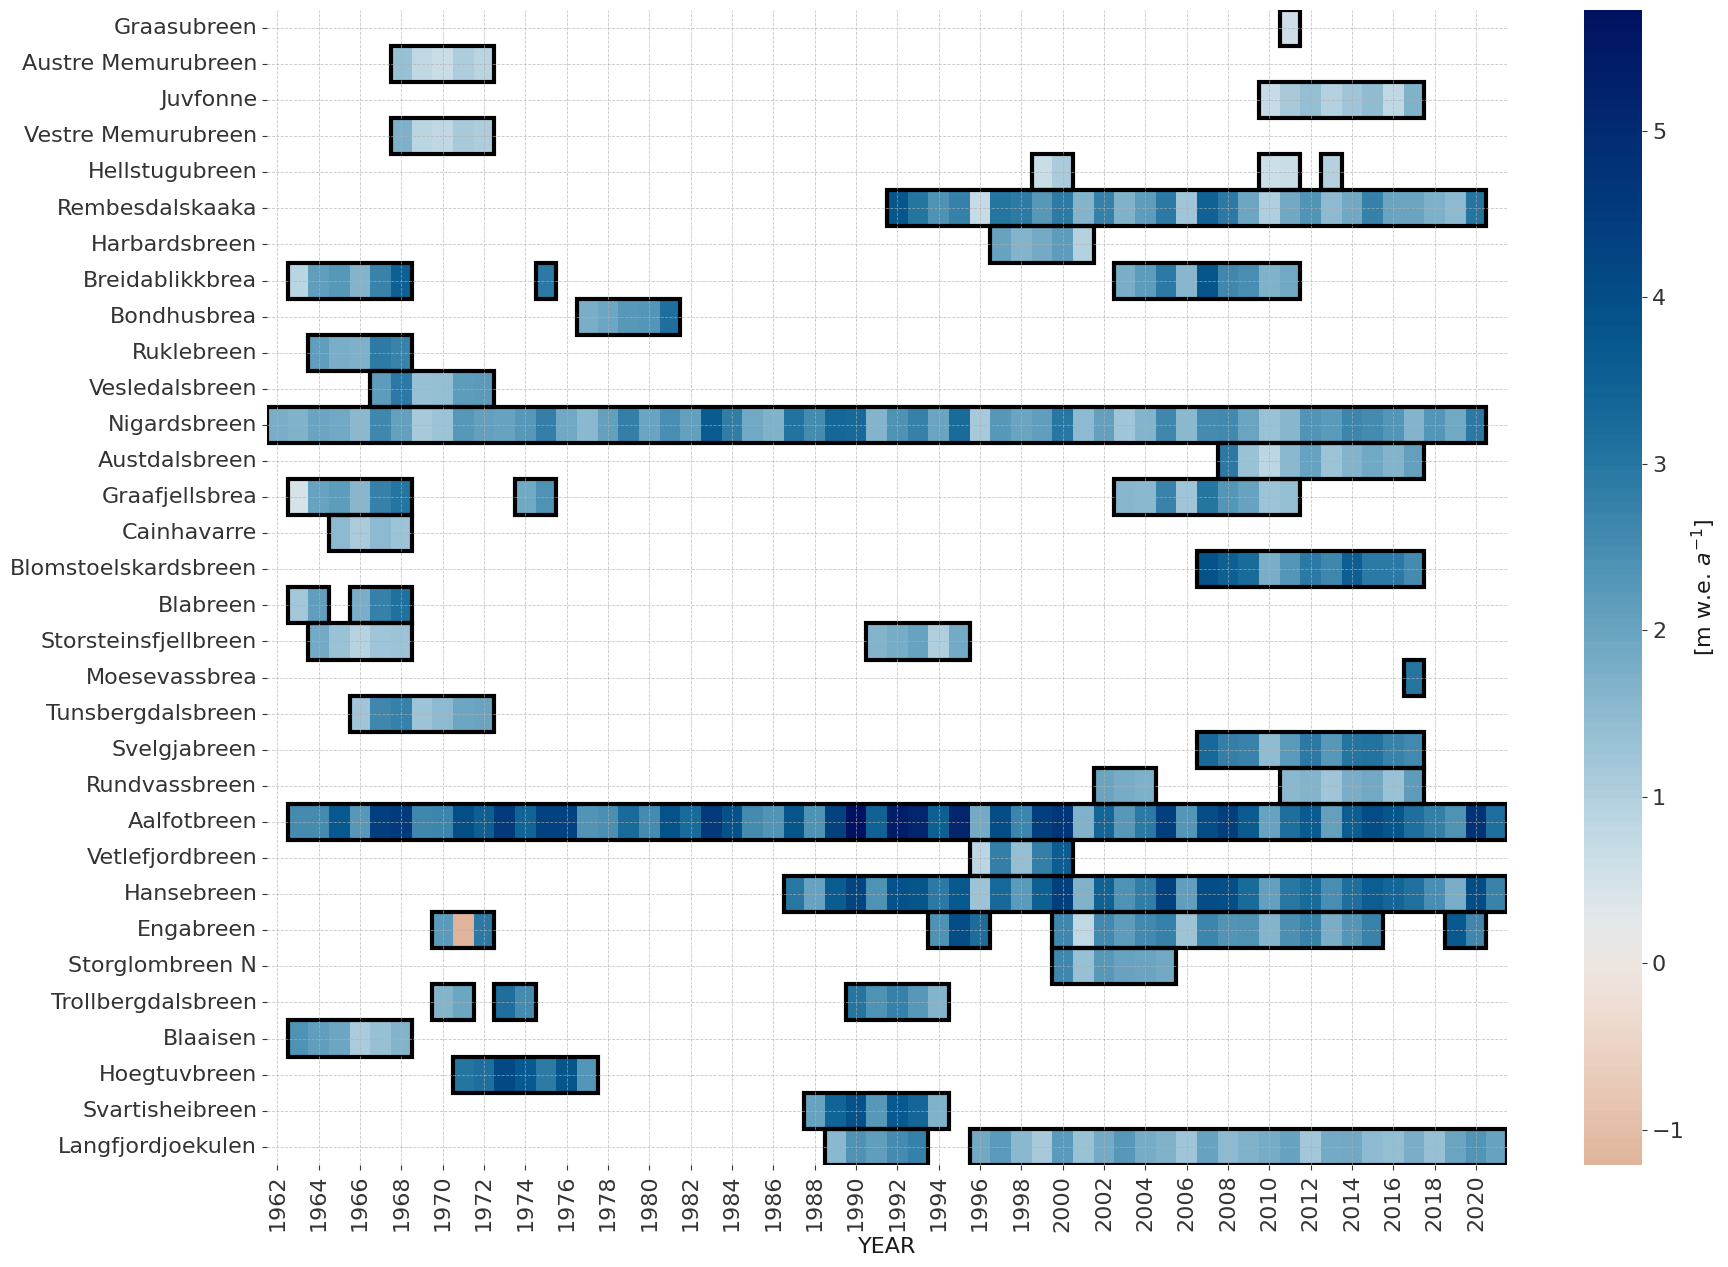

In [37]:
plotHeatmap(test_glaciers, data_monthly, period='annual')

plotHeatmap(test_glaciers, data_monthly, period='winter')

Test glaciers: (32) ['Langfjordjoekulen' 'Blaaisen' 'Storsteinsfjellbreen' 'Cainhavarre'
 'Rundvassbreen' 'Storglombreen N' 'Engabreen' 'Svartisheibreen'
 'Hoegtuvbreen' 'Trollbergdalsbreen' 'Aalfotbreen' 'Hansebreen'
 'Vetlefjordbreen' 'Nigardsbreen' 'Tunsbergdalsbreen' 'Vesledalsbreen'
 'Austdalsbreen' 'Harbardsbreen' 'Juvfonne' 'Graasubreen' 'Hellstugubreen'
 'Austre Memurubreen' 'Vestre Memurubreen' 'Rembesdalskaaka' 'Blabreen'
 'Graafjellsbrea' 'Breidablikkbrea' 'Ruklebreen' 'Bondhusbrea'
 'Svelgjabreen' 'Moesevassbrea' 'Blomstoelskardsbreen']
Percentage of test size: 20.01%
Size of test set: 60265
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tie

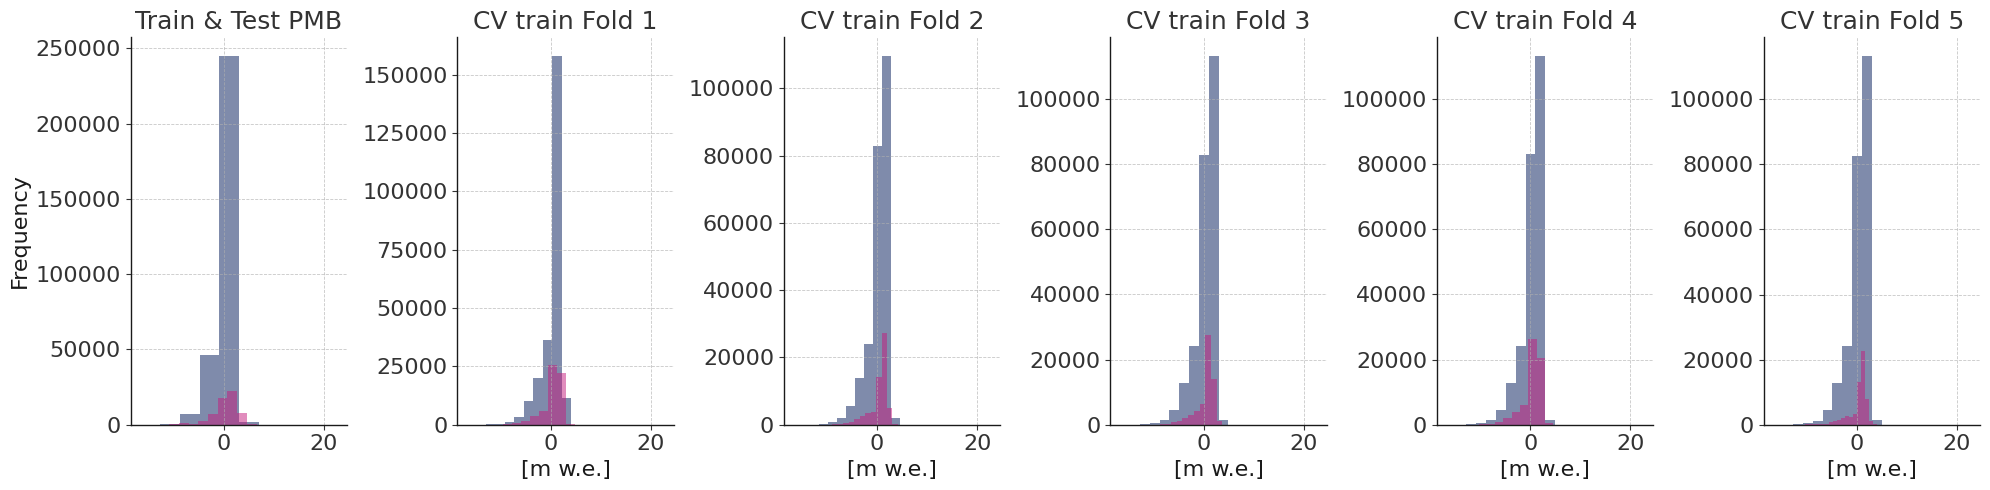

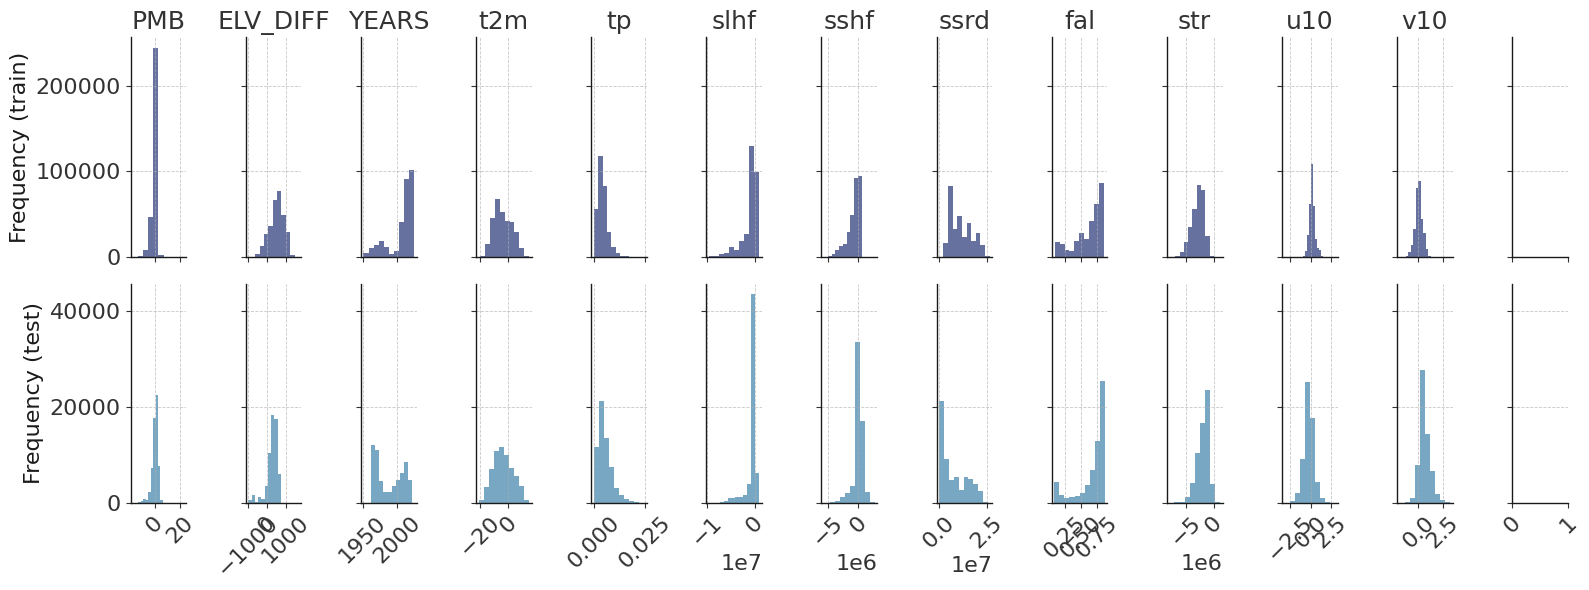

In [38]:
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)

print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))
test_perc = (len(test_set['df_X']) / len(train_set['df_X'])) * 100
print('Percentage of test size: {:.2f}%'.format(test_perc))
print('Size of test set:', len(test_set['df_X']))
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                       train_set['splits_vals']))
print('Size of train set:', len(train_set['df_X']))

visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

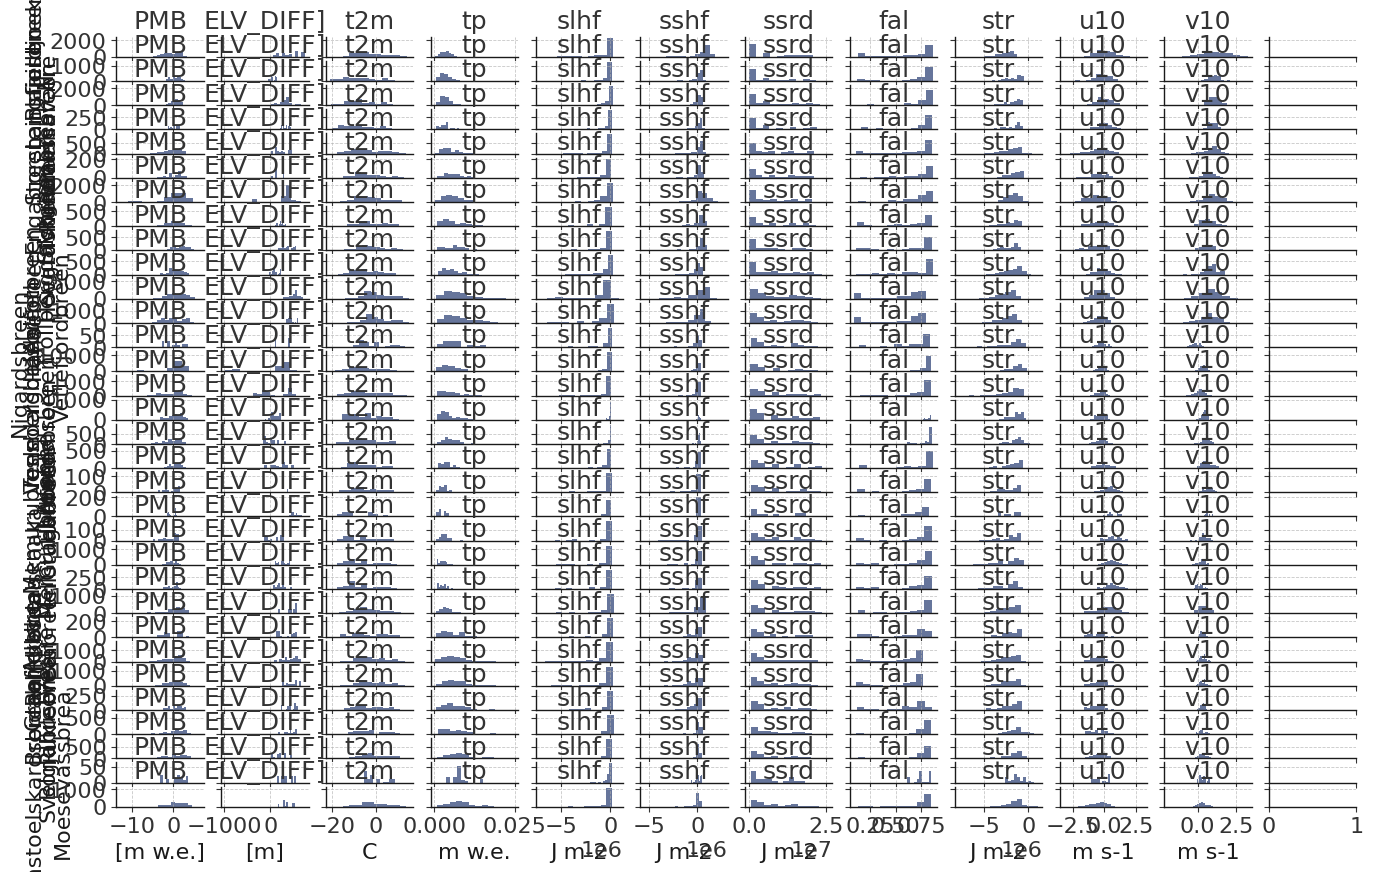

In [39]:
# plot distributions of test glaciers:
f, ax = plt.subplots(len(test_glaciers),
                     len(vois_climate) + 3,
                     figsize=(16, 10),
                     sharey='row',
                     sharex='col')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl['POINT_BALANCE'].plot.hist(ax=ax[i, 0],
                                          color=color_dark_blue,
                                          alpha=0.6,
                                          density=False)
    ax[i, 0].set_title('PMB')
    ax[i, 0].set_ylabel(test_gl)
    ax[i, 0].set_xlabel('[m w.e.]')
    test_df_gl['ELEVATION_DIFFERENCE'].plot.hist(ax=ax[i, 1],
                                                 color=color_dark_blue,
                                                 alpha=0.6,
                                                 density=False)
    ax[i, 1].set_title('ELV_DIFF]')
    ax[i, 1].set_xlabel('[m]')

    for j, voi_clim in enumerate(vois_climate):
        ax[i, 2 + j].set_title(voi_clim)
        test_df_gl[voi_clim].plot.hist(ax=ax[i, 2 + j],
                                       color=color_dark_blue,
                                       alpha=0.6,
                                       density=False)
        ax[i, 2 + j].set_xlabel(vois_units[voi_clim])

plt.tight_layout()

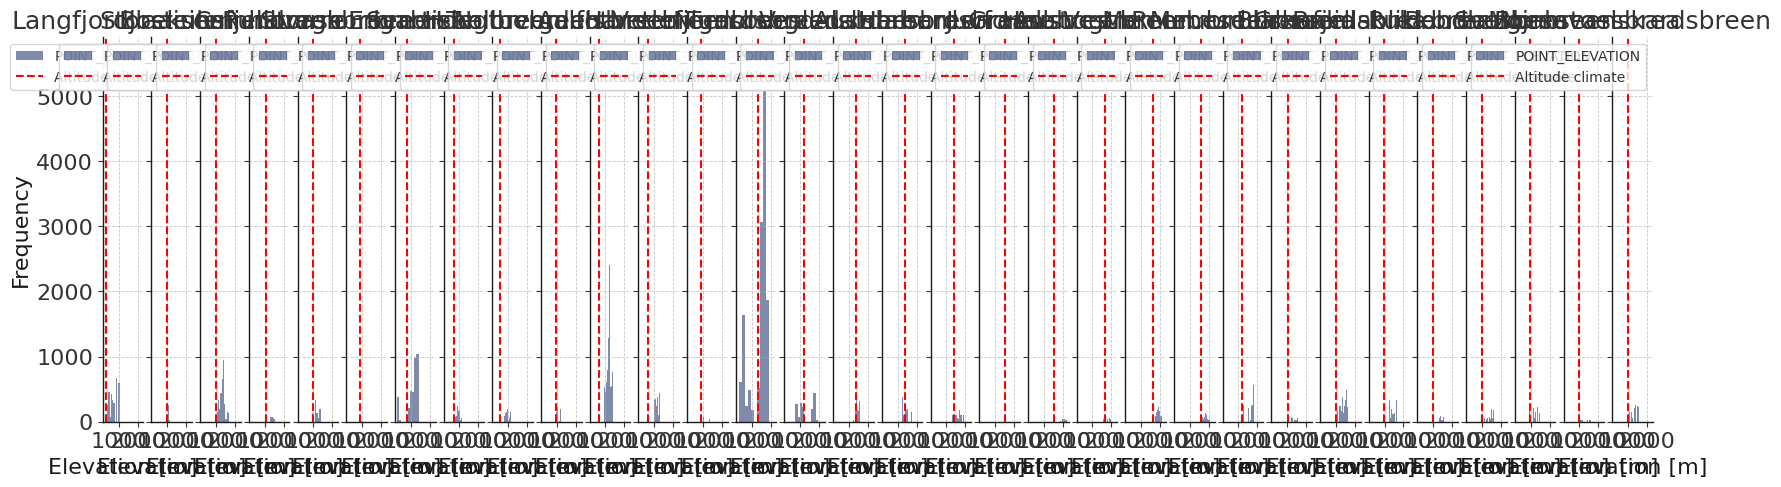

In [40]:
f, ax = plt.subplots(1,
                     len(test_glaciers),
                     figsize=(20, 5),
                     sharey='row',
                     sharex='row')

for i, test_gl in enumerate(test_glaciers):
    test_df_gl = test_set['df_X'][test_set['df_X'].GLACIER == test_gl]
    test_df_gl.POINT_ELEVATION.plot.hist(color=color_dark_blue,
                                         alpha=0.5,
                                         density=False,
                                         ax=ax[i])
    # add vertical line for altitude climate
    alt_climate = test_df_gl.ALTITUDE_CLIMATE.mean()
    ax[i].axvline(x=alt_climate,
                  color='red',
                  linestyle='--',
                  label='Altitude climate')
    ax[i].set_xlabel('Elevation [m]')
    ax[i].legend()
    ax[i].set_title(test_gl)
plt.tight_layout()

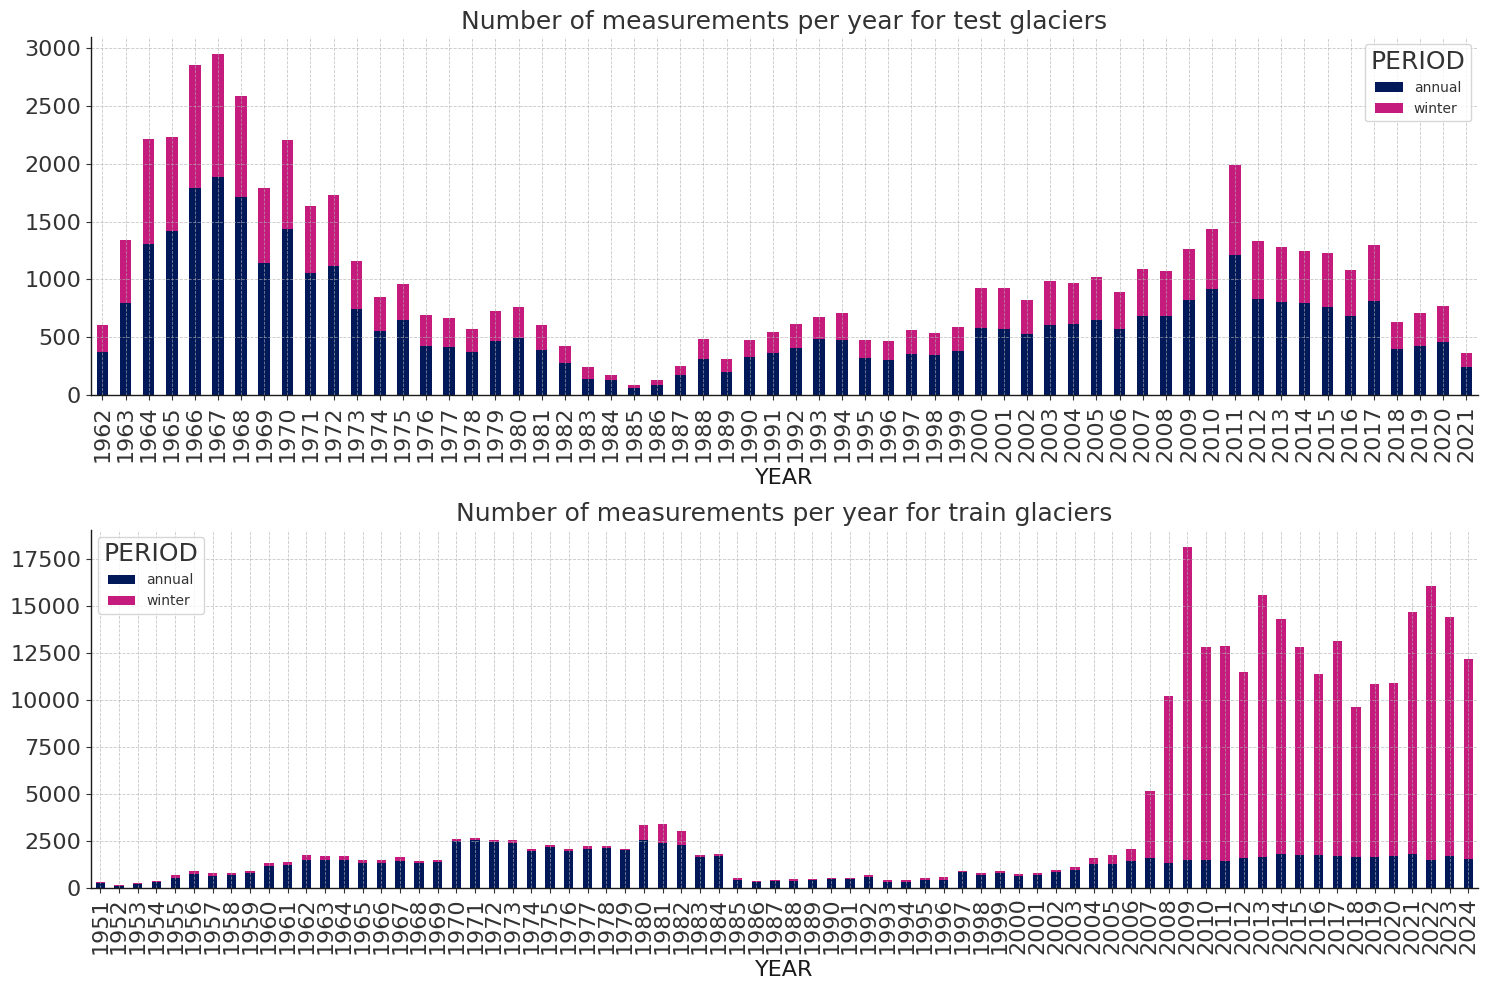

In [41]:
# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
data_test.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
data_train.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

#### XGBoost

In [42]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

#### Grid Search

In [43]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = True
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'CH_train_NOR_test.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'CH_train_NOR_test.pkl')  # model with SGI aspect&slope

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (301118, 25)
Shape of testing dataset: (60265, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness']
Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:44:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:44:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:44:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:44:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "cfg" } are not used.

  warnings.warn(smsg, UserWarning)
/home/mburlet/anaconda3/envs/MassBalanceMachine/lib/python3.

Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.2039305227297354
Shape of the test: (60265, 14)
Overall score: 2.9116013133486205
CPU times: user 8min 33s, sys: 8.45 s, total: 8min 41s
Wall time: 35min 16s


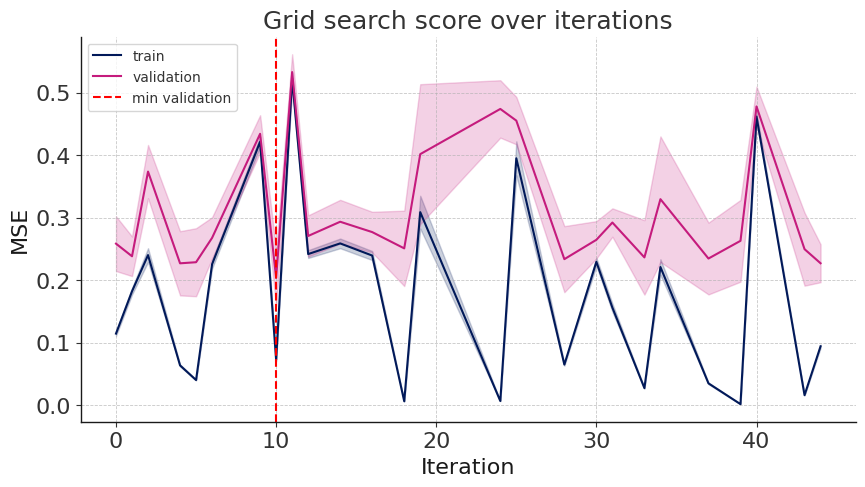

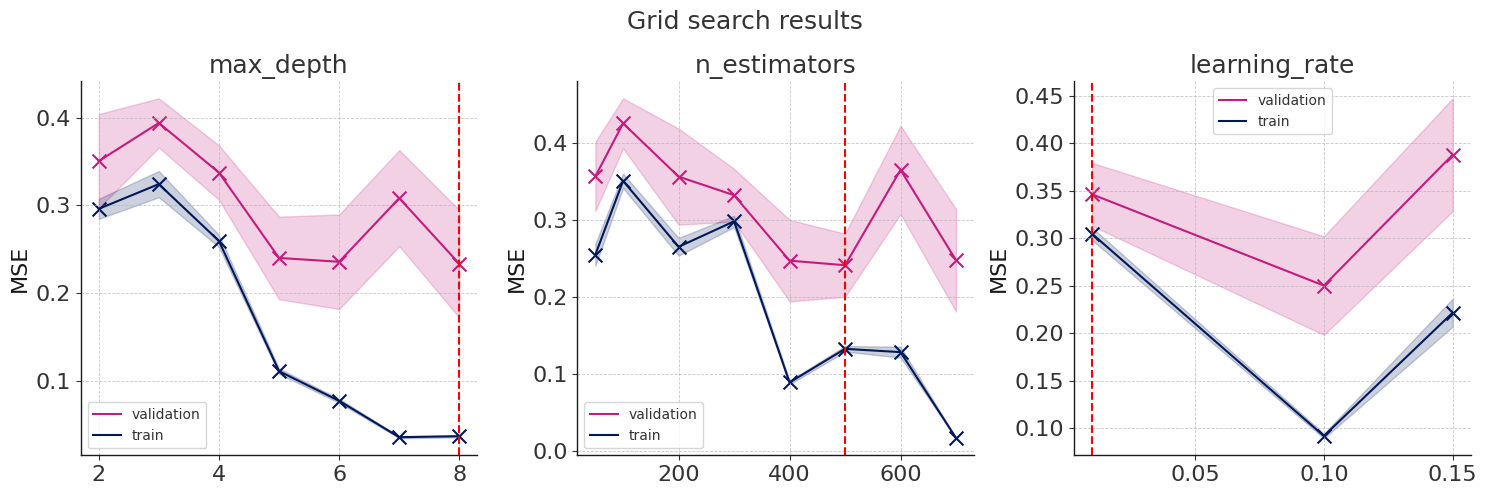

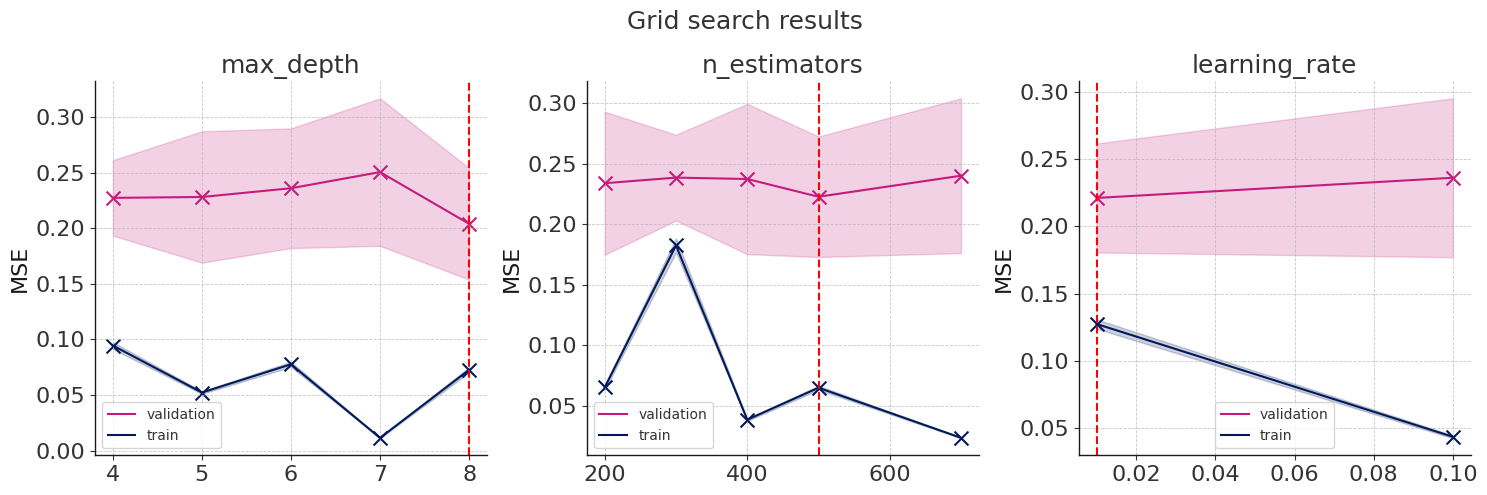

In [44]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

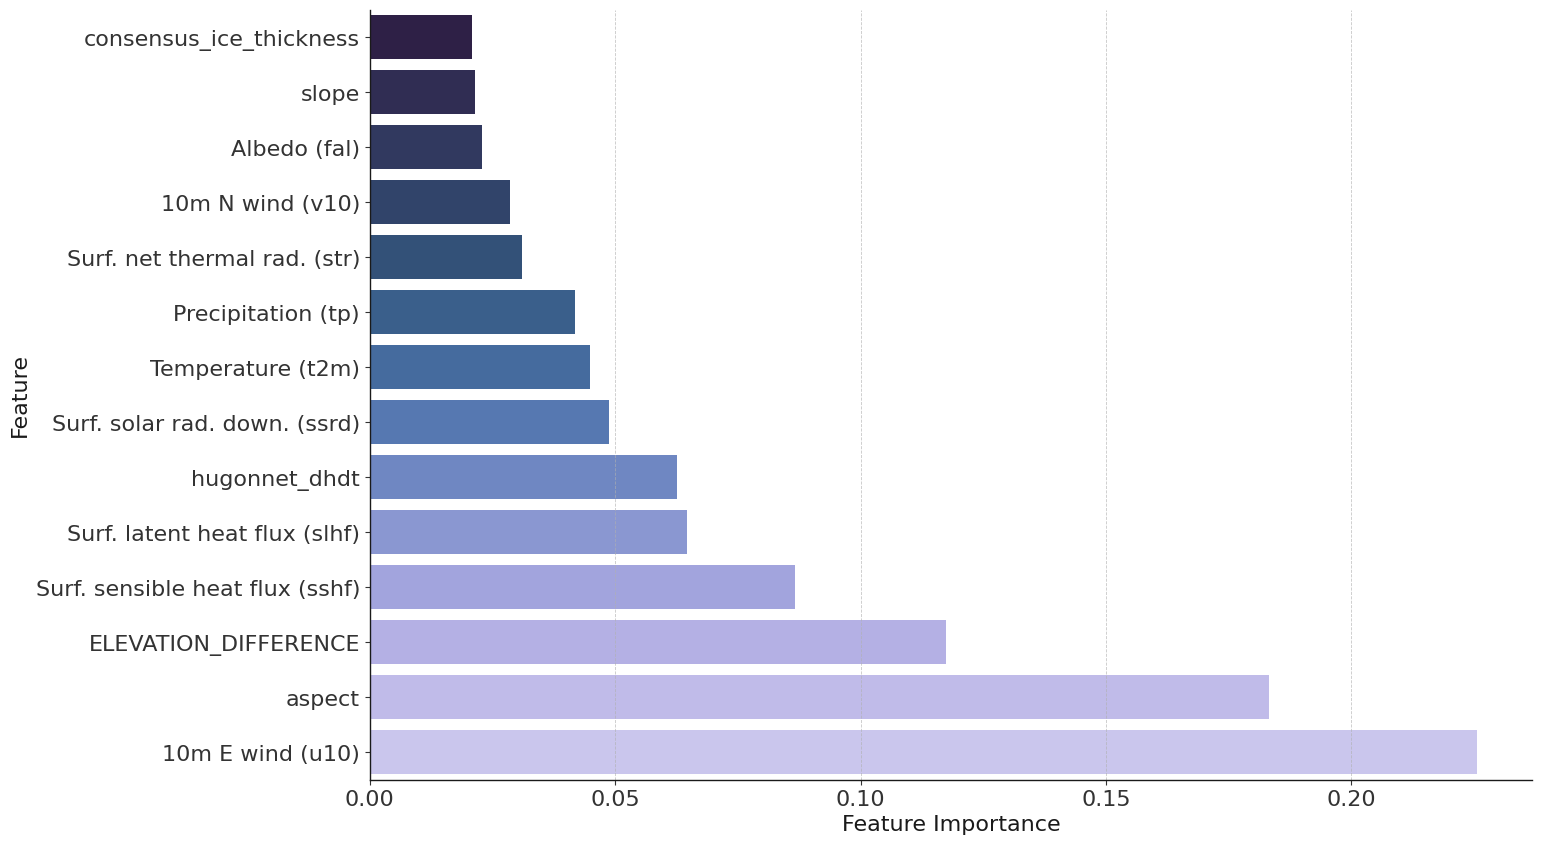

In [45]:
FIPlot(best_estimator, feature_columns, vois_climate)

Shape of the test: (60265, 14)
{'Langfjordjoekulen': '#a6cee3', 'Blaaisen': '#1f78b4', 'Storsteinsfjellbreen': '#b2df8a', 'Cainhavarre': '#33a02c', 'Rundvassbreen': '#fb9a99', 'Storglombreen N': '#e31a1c', 'Engabreen': '#fdbf6f', 'Svartisheibreen': '#ff7f00', 'Hoegtuvbreen': '#cab2d6', 'Trollbergdalsbreen': '#6a3d9a', 'Aalfotbreen': '#ffff99', 'Hansebreen': '#b15928', 'Vetlefjordbreen': '#8dd3c7', 'Nigardsbreen': '#ffffb3', 'Tunsbergdalsbreen': '#bebada', 'Vesledalsbreen': '#fb8072', 'Austdalsbreen': '#80b1d3', 'Harbardsbreen': '#fdb462', 'Juvfonne': '#b3de69', 'Graasubreen': '#fccde5', 'Hellstugubreen': '#d9d9d9', 'Austre Memurubreen': '#bc80bd', 'Vestre Memurubreen': '#ccebc5', 'Rembesdalskaaka': '#ffed6f', 'Blabreen': '#66c2a5', 'Graafjellsbrea': '#fc8d62', 'Breidablikkbrea': '#8da0cb', 'Ruklebreen': '#e78ac3', 'Bondhusbrea': '#a6d854', 'Svelgjabreen': '#ffd92f', 'Moesevassbrea': '#e5c494', 'Blomstoelskardsbreen': '#b3b3b3'}


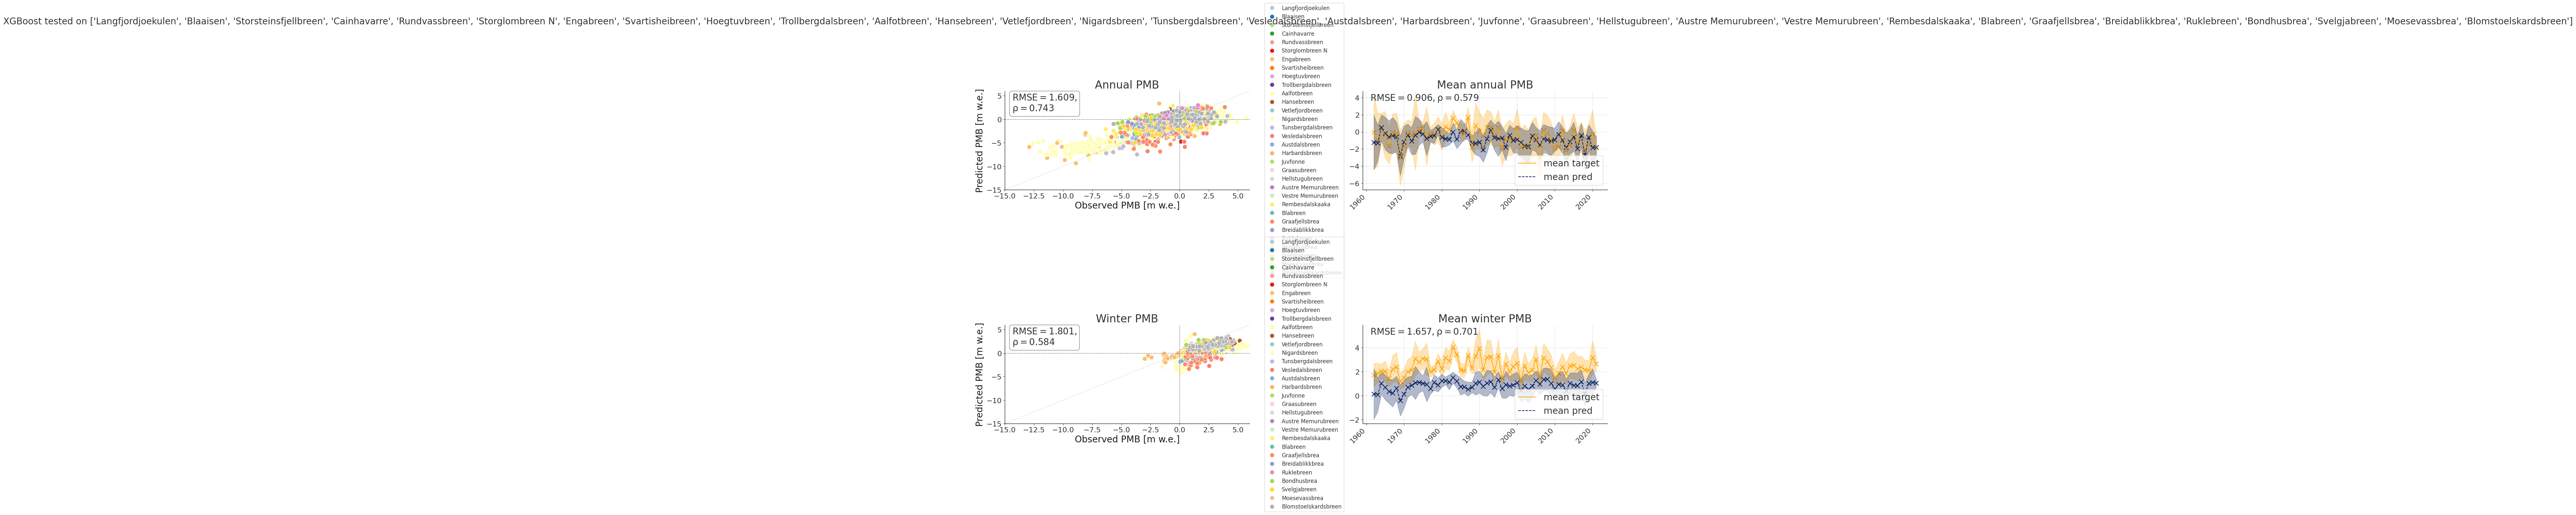

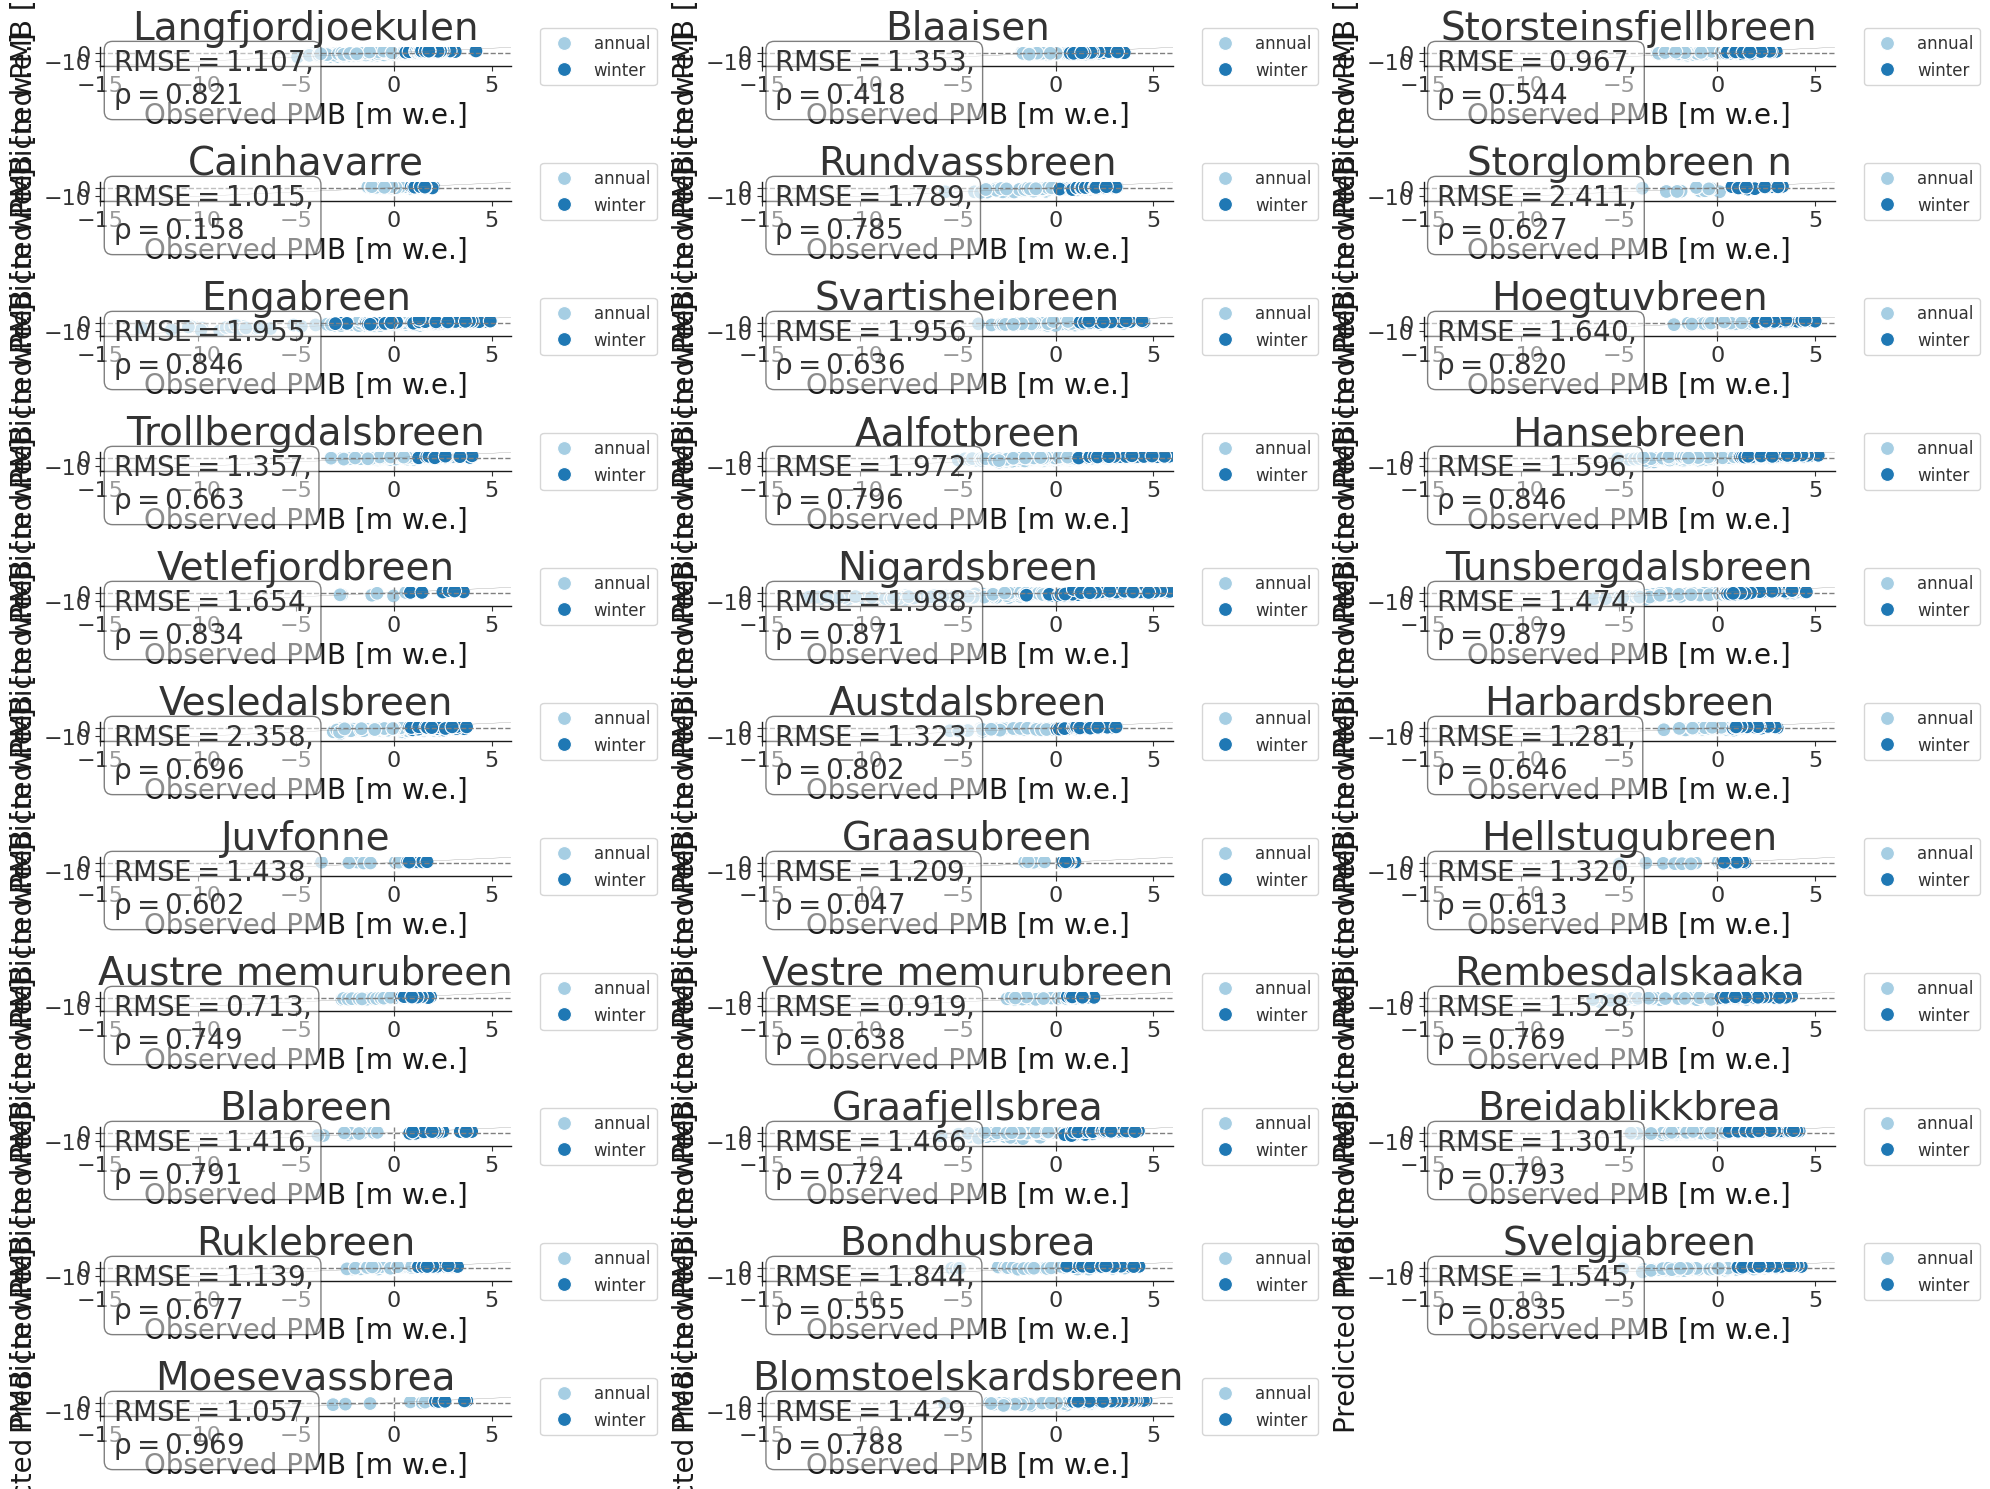

In [46]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical) + ['pcsr']
# feature_columns = ['ELEVATION_DIFFERENCE'
#                    ] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_glaciers}', fontsize=20)
plt.tight_layout()

In [ ]:
# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, figsize=(20, 15))

In [ ]:
FIPlot(custom_model, feature_columns, vois_climate)

## Extrapolate in space


### Geodetic MB:

In [ ]:
geodetic_mb = get_geodetic_MB()

# filter to glaciers with potential clear sky radiation data
geodetic_mb = geodetic_mb[geodetic_mb.glacier_name.isin(glDirect)]

# get years per glacier
years_start_per_gl = geodetic_mb.groupby(
    'glacier_name')['Astart'].unique().apply(list).to_dict()
years_end_per_gl = geodetic_mb.groupby('glacier_name')['Aend'].unique().apply(
    list).to_dict()

periods_per_glacier = defaultdict(list)
geoMB_per_glacier = defaultdict(list)

# Iterate through the DataFrame rows
for _, row in geodetic_mb.iterrows():
    glacier_name = row['glacier_name']
    start_year = row['Astart']
    end_year = row['Aend']
    geoMB = row['Bgeod']

    # Append the (start, end) tuple to the glacier's list
    # Only if period is longer than 5 years
    if end_year - start_year >= 5:
        periods_per_glacier[glacier_name].append((start_year, end_year))
        geoMB_per_glacier[glacier_name].append(geoMB)

# sort by glacier_list
periods_per_glacier = dict(sorted(periods_per_glacier.items()))
geoMB_per_glacier = dict(sorted(geoMB_per_glacier.items()))

### Glacier wide MB: 
Compute 2D fields.

In [ ]:
glDirect = [
    re.search(r'xr_direct_(.*?).zarr', f).group(1)
    for f in os.listdir(path_pcsr + 'zarr/')
]
data_glamos = data_glamos[data_glamos.GLACIER.isin(glDirect)]
glacier_list = list(data_glamos.GLACIER.unique())
print('Number of glaciers with pcsr:', len(glacier_list))

# satellite_glaciers = [
#     'adler', 'aletsch', 'allalin', 'basodino', 'clariden', 'findelen', 'gries',
#     'hohlaub', 'limmern', 'oberaar', 'plattalva', 'rhone', 'sanktanna',
#     'schwarzbach', 'schwarzberg'
# ]

geodetic_glaciers = periods_per_glacier.keys()
print('Number of glaciers with geodetic MB:', len(geodetic_glaciers))

# Intersection of both
common_glaciers = list(set(geodetic_glaciers) & set(glacier_list))
print('Number of common glaciers:', len(common_glaciers))

# Sort glaciers by area
gl_area = get_gl_area()
gl_area['clariden'] = gl_area['claridenL']


# Sort the lists by area if available in gl_area
def sort_by_area(glacier_list, gl_area):
    return sorted(glacier_list, key=lambda g: gl_area.get(g, 0), reverse=False)


glacier_list = sort_by_area(common_glaciers, gl_area)
glacier_list

#### GLAMOS grids & Normal T & P:

In [ ]:
RUN = False
if RUN:
    # Define paths
    path_save_glw = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/distributed_MB_grids/MBM/glamos_dems/'
    path_xr_grids = '/home/mburlet/scratch/data/DATA_MB/DEV/GLAMOS/topo/GLAMOS_DEM/xr_masked_grids/'  # GLAMOS DEMs

    emptyfolder(path_save_glw)

    # Feature columns
    vois_climate = [
        't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
    ]
    # feature_columns = ['ELEVATION_DIFFERENCE'
    #                    ] + list(vois_climate) + list(vois_topographical)
    feature_columns = [
        'ELEVATION_DIFFERENCE'
    ] + list(vois_climate) + list(vois_topographical) + ['pcsr']
    all_columns = feature_columns + cfg.fieldsNotFeatures
    print('Running for feature columns:', all_columns)

    for glacier_name in glacier_list:
        glacier_path = os.path.join(path_glacier_grid_glamos, glacier_name)

        if not os.path.exists(glacier_path):
            print(f"Folder not found for {glacier_name}, skipping...")
            continue

        glacier_files = sorted(
            [f for f in os.listdir(glacier_path) if glacier_name in f])

        print(f"Processing {glacier_name} ({len(glacier_files)} files)")

        glacier_files = sort_by_area(glacier_files, gl_area)

        for file_name in tqdm(glacier_files,
                              desc=f"Processing {glacier_name}",
                              leave=False):
            year = int(file_name.split('_')[2].split('.')[0])

            # Load parquet input glacier grid file in monthly format (pre-processed)
            df_grid_monthly = pd.read_parquet(
                os.path.join(path_glacier_grid_glamos, glacier_name,
                             file_name))
            df_grid_monthly.drop_duplicates(inplace=True)

            # Keep only necessary columns, avoiding missing columns issues
            df_grid_monthly = df_grid_monthly[[
                col for col in all_columns if col in df_grid_monthly.columns
            ]]

            # Add GLWD_ID
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly.apply(
            #     lambda x: get_hash(f"{x.GLACIER}_{x.YEAR}"), axis=1)
            # df_grid_monthly['GLWD_ID'] = df_grid_monthly['GLWD_ID'].astype(str)

            # Create geodata object
            geoData = mbm.GeoData(df_grid_monthly)

            # Computes and saves gridded MB for a year and glacier
            path_glacier_dem = os.path.join(path_xr_grids,
                                            f"{glacier_name}_{year}.zarr")
            geoData.gridded_MB_pred(custom_model,
                                    glacier_name,
                                    year,
                                    all_columns,
                                    path_glacier_dem,
                                    path_save_glw,
                                    cfg,
                                    save_monthly_pred=True)

In [ ]:
glacier_name = 'clariden'
year = 2010
# open xarray
xr.open_dataset(
    path_save_glw +
    f'{glacier_name}/{glacier_name}_{year}_annual.zarr').pred_masked.plot()